# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE THE PROBLEM

### Can we predict the salaries of the job postings?
Given the previous history of job postings and salaries can we predict the future salary of a job posting.
#### --> Goals (What are we trying to achieve through this project)
    -> Help Companies hire the right candities at the right salary
    -> Help employees get a realistic estimate on the salary of their job

In [155]:
#import your libraries

#Analysis Libraries
import pandas as pd
import numpy as np
import os

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#importing xgboost regressor
from xgboost import XGBRegressor

#Importing tensorflow libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.models import load_

#Keras tuner
import kerastuner as kt
from kerastuner import HyperModel
from kerastuner import RandomSearch, BayesianOptimization, Hyperband

#etc

#your info here
__author__ = "Saitejas Mopuri"
__email__ = "saitejasmopuri@gmail.com"

## Part 2 - DISCOVER (EDA)

### ---- Loading the data ----

In [10]:
#loading the data into a Pandas dataframe
train_features = pd.read_csv('./data/train_features.csv')
train_salaries = pd.read_csv('./data/train_salaries.csv')

In [11]:
train_features.head()

jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  
0   HEALTH               10                   83  
1      WEB                3                   73  
2   HEALTH               10                   38  
3     AUTO                8                   17  
4  FINANCE                8                   16

In [12]:
train_salaries.head()

jobId  salary
0  JOB1362684407687     130
1  JOB1362684407688     101
2  JOB1362684407689     137
3  JOB1362684407690     142
4  JOB1362684407691     163

### --Initial analysis of the data--

we have 8 columns and 2 of them are id columns which might not have any realation with the other columns.

In [13]:
#Number of training examples
train_features.count()

jobId                  1000000
companyId              1000000
jobType                1000000
degree                 1000000
major                  1000000
industry               1000000
yearsExperience        1000000
milesFromMetropolis    1000000
dtype: int64

In [14]:
train_salaries.count()

jobId     1000000
salary    1000000
dtype: int64

The number of train_feature entries match with the number of train_salaries entries 
which is good news.

### ----Cleaning the data ----

In [15]:
train_features.describe()

yearsExperience  milesFromMetropolis
count   1000000.000000       1000000.000000
mean         11.992386            49.529260
std           7.212391            28.877733
min           0.000000             0.000000
25%           6.000000            25.000000
50%          12.000000            50.000000
75%          18.000000            75.000000
max          24.000000            99.000000

In [16]:
train_salaries[train_salaries['salary'] == 0]

jobId  salary
30559   JOB1362684438246       0
495984  JOB1362684903671       0
652076  JOB1362685059763       0
816129  JOB1362685223816       0
828156  JOB1362685235843       0

We have five examples with 0 salaries we are just going to drop them


In [21]:
#Before we drop them let's merge the salaries with 
# features that way we can get rid of the five examples in the 
#features as well
complete_df = pd.concat([train_features, train_salaries['salary']], axis=1,)
complete_df.head()

jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  salary  
0   HEALTH               10                   83     130  
1      WEB                3                   73     101  
2   HEALTH               10                   38     137  
3     AUTO                8                   17     142  
4  FINANCE                8                   16     163

In [22]:
#Removing the zero salaries
complete_df = complete_df[complete_df.salary != 0]
complete_df.count()

jobId                  999995
companyId              999995
jobType                999995
degree                 999995
major                  999995
industry               999995
yearsExperience        999995
milesFromMetropolis    999995
salary                 999995
dtype: int64

In [23]:
#Checking for null values
complete_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

Awesome no null values

### ---- Data Visualization ----

In [37]:
def visualization_plot(feature_x, data, feature_y=None,  hue=None, kde_line=False, size=(14,7), bins=100, plot_type=''):
    '''
    This function plots the specified plot_type if the 
    plot type does not exist it will raise a error.
    plot_type should in the fromat of a string
    '''
    plt.figure(figsize=size)

    if plot_type == 'dist' or plot_type == 'distribution':  
        sns.distplot(data[feature_x],bins=bins, kde=kde_line)
    
    elif plot_type == 'count':
        sns.countplot(x=feature_x, data=data, hue=hue)
    
    elif plot_type == 'violin' and feature_y != NONE:
        sns.violinplot(x=feature_x, y=feature_y, data=data)
    
    elif plot_type == 'bar':
        sns.barplot(x=feature_x, y=feature_y, data=data)
    else:
        raise ValueError('Invalid plot type\n or\n the type of plot does not exist in the method\n')
        return -1
    if feature_y == None:
        plt.savefig('./graphs/png/{}_{}.png'.format(feature_x, plot_type))
        plt.savefig('./graphs/pdf/{}_{}.pdf'.format(feature_x, plot_type))
    elif feature_y != None:
        plt.savefig('./graphs/png/{}_{}_{}.png'.format(feature_x,feature_y, plot_type))
        plt.savefig('./graphs/pdf/{}_{}_{}.pdf'.format(feature_x,feature_y, plot_type))
    

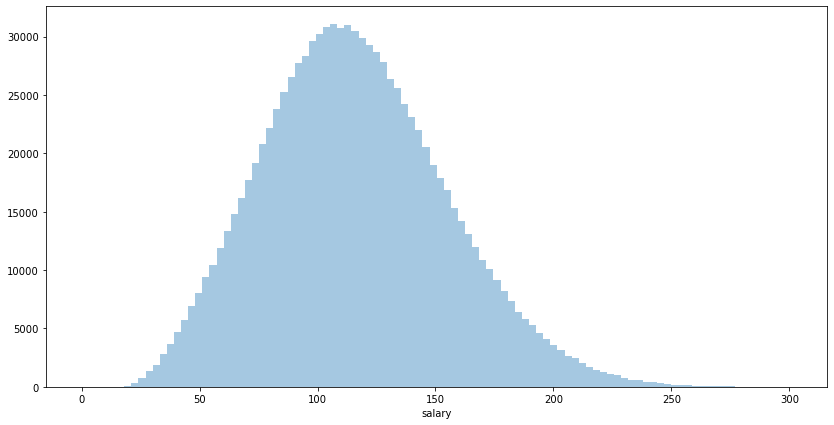

In [41]:
#Checking out the distribution of the salary range
visualization_plot(feature_x='salary', data=train_salaries,plot_type='dist')

We have more salaries around the range of 100 to 150 compared to 50-100 and 150-200

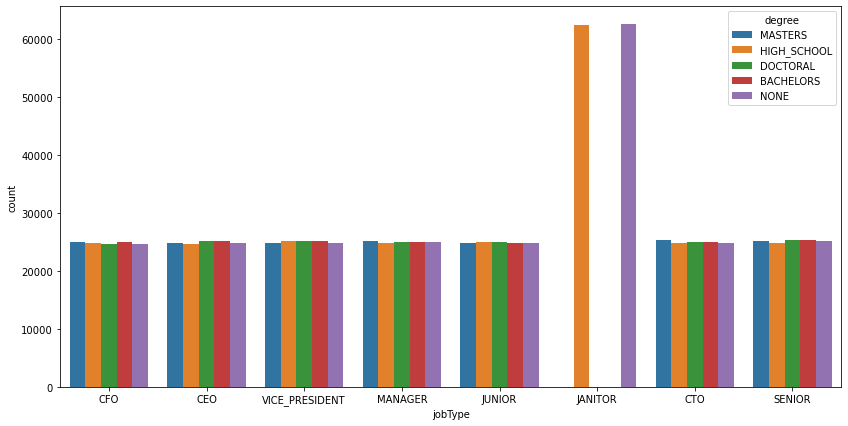

In [42]:
#My hypothesis is that to be a CFO of a company you need at least a 
#masters maybe they forgot to mention the requirment of the degree
visualization_plot(feature_x='jobType', hue='degree', data=complete_df, plot_type='count')

My hypothesis was wrong someone with high school diploma can become CEO or CFO

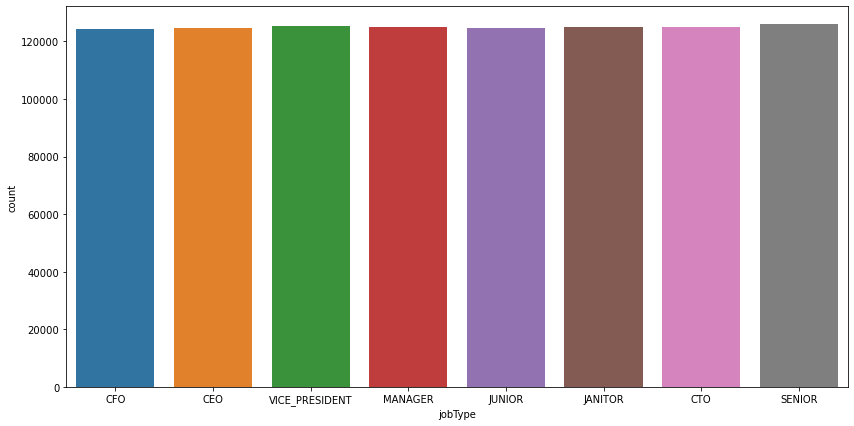

In [43]:
#Checking out the job type to see if these featuer is balanced or not
visualization_plot(feature_x="jobType", data=train_features, plot_type='count')

Awesome everything is well balanced

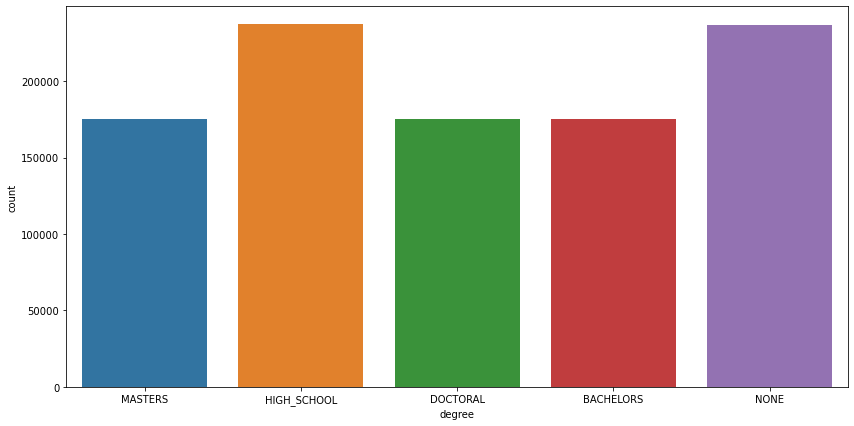

In [45]:
visualization_plot(feature_x='degree', data=train_features, plot_type='count')

We have more jobs requireing high school diploma than masters, doctoral and bachelors. 
But there are several jobs that say none. Maybe they forgot to mention we can perform some feature engineering on it or maybe these jobs require no degree

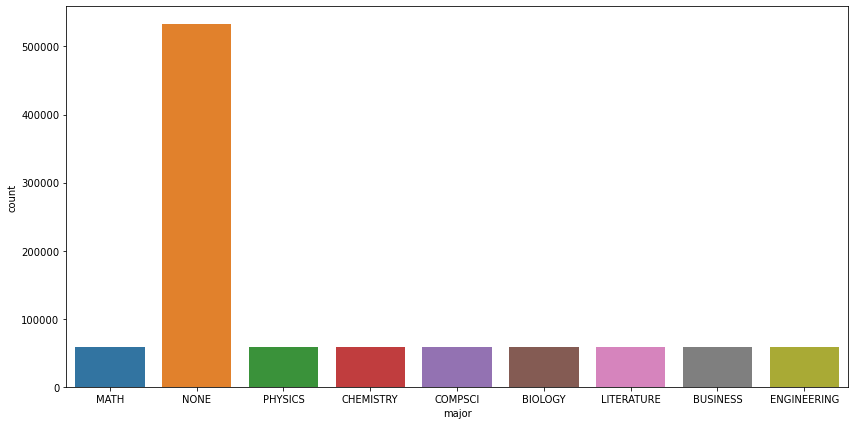

In [46]:
visualization_plot(feature_x='major', data=train_features, plot_type='count')

We have the same problem in here as well. Many jobs forgot to mention the majors they are looking for or maybe there is no major requirment for the job.

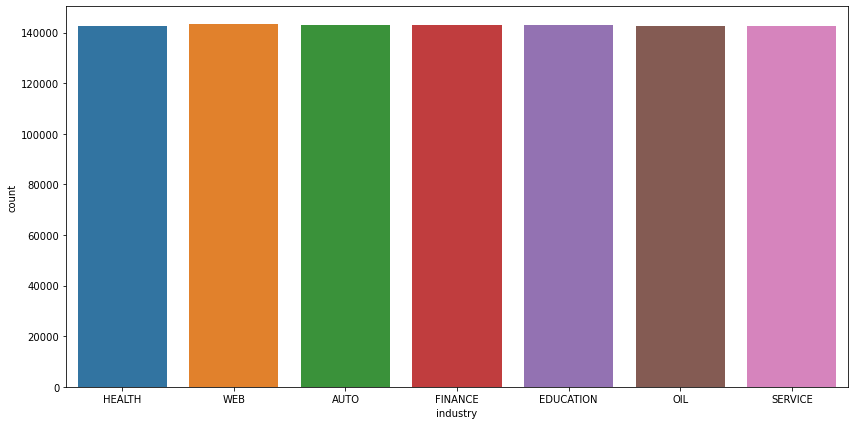

In [47]:
visualization_plot(feature_x='industry', data=train_features, plot_type='count')

Awesome we have same amount of jobs from different industry

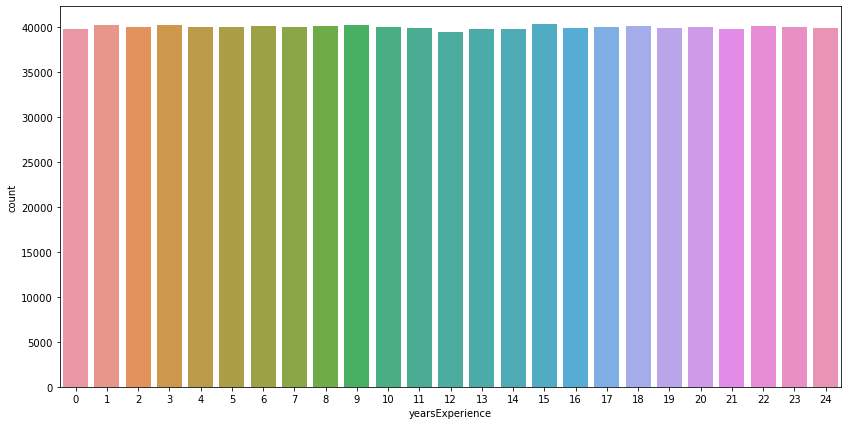

In [48]:
visualization_plot(feature_x='yearsExperience', data=train_features, plot_type='count')

The the years of experience ranges from 0-24

In [26]:
complete_df.corr()

yearsExperience  milesFromMetropolis    salary
yearsExperience             1.000000             0.000672  0.375013
milesFromMetropolis         0.000672             1.000000 -0.297686
salary                      0.375013            -0.297686  1.000000

We can see a very strong corelation with salary and years of expereince

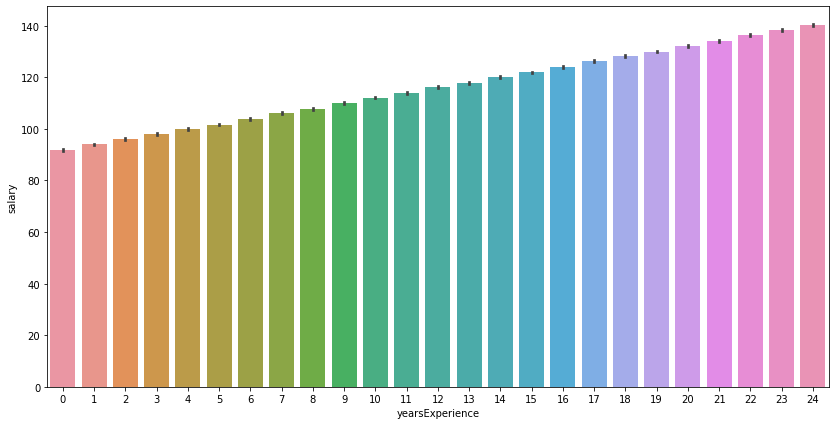

In [52]:
visualization_plot(feature_x='yearsExperience', feature_y='salary', 
                   data=complete_df, plot_type='bar')

### ---- Establishing a baseline ----

In [73]:
baseline_df = complete_df.groupby(by='industry').mean()
baseline_df = baseline_df.drop(labels='milesFromMetropolis', axis=1)
baseline_df = baseline_df.rename(columns={'salary':'avg_salary'})
baseline_df = pd.merge(complete_df, baseline_df, on='industry')
baseline_df = baseline_df[['salary', 'avg_salary']]
error = mean_squared_error(baseline_df['avg_salary'], baseline_df['salary'])
print('The baseline model mean squared error : {}'.format(error))

The baseline model mean squared error : 1367.1229507852554


#### MSE of 1367.1229507852554 is what we are trying to beat

### ---- Hypothesize solution ----

In [74]:
#brainstorming couple of models that I think may improve results over the baseline model based
#on my hypothesis 
#1.XGBoost regressor
#2. Densly connected neural network with Hyperparameter tuning

## Part 3 - DEVELOP

### ---- Engineering features  ----

In [30]:
#making sure that data is ready for modeling
#creating any new features needed to potentially enhance model

In [82]:
#Getting rid of jobId and company Id and making dummies
# for jobType, degree, major, industry.
def pre_processing(data = complete_df):
    '''
    Gets rid of the jobId and company Id and makes dummies
     for jobType, degree, major, industry.
    '''
    data = data.drop(labels=['companyId', 'jobId'], axis=1)
    data = pd.get_dummies(data=data, columns=['jobType', 
                                                'degree', 
                                                'major', 
                                                'industry'], drop_first=True)
    return data

In [77]:
#Using pandas dummies for one hot encoding
complete_df = pre_processing()
complete_df.head()

yearsExperience  milesFromMetropolis  salary  jobType_CFO  jobType_CTO  \
0               10                   83     130            1            0   
1                3                   73     101            0            0   
2               10                   38     137            0            0   
3                8                   17     142            0            0   
4                8                   16     163            0            0   

   jobType_JANITOR  jobType_JUNIOR  jobType_MANAGER  jobType_SENIOR  \
0                0               0                0               0   
1                0               0                0               0   
2                0               0                0               0   
3                0               0                1               0   
4                0               0                0               0   

   jobType_VICE_PRESIDENT  ...  major_LITERATURE  major_MATH  major_NONE  \
0                       0  ...                 0           1           0   
1                       0  ...                 0           0           1   
2                       1  ...                 0           0           0   
3                       0  ...                 0           0           0   
4                       1  ...                 0           0           0   

   major_PHYSICS  industry_EDUCATION  industry_FINANCE  industry_HEALTH  \
0              0                   0                 0                1   
1              0                   0                 0                0   
2              1                   0                 0                1   
3              0                   0                 0                0   
4              1                   0                 1                0   

   industry_OIL  industry_SERVICE  industry_WEB  
0             0                 0             0  
1             0                 0             1  
2             0                 0             0  
3             0                 0             0  
4             0                 0             0  

[5 rows x 28 columns]

The data is cleaned and in ready to be trained

In [1]:
#Features will be our independent varialbles
features = complete_df.drop(labels='salary', axis=1)
features.head()

In [2]:
#salaries will be our dependent variable
salaries = complete_df['salary']
salaries.head()

In [80]:
#We are going to make a 60/20/20 spilt training/validation/test split
job_features_train, job_features_valid,salaries_train, salaries_valid = train_test_split(features, salaries, test_size=0.4, random_state=101)
job_features_valid, job_features_test,salaries_valid, salaries_test = train_test_split(job_features_valid, salaries_valid, test_size=0.5, random_state=101)

In [81]:
print(job_features_train.count()[0])
print(job_features_valid.count()[0])
print(job_features_test.count()[0])

599997
199999
199999


In [3]:
#Using MinMaxScaler to standardize the features
scaler = MinMaxScaler()
job_features_train[['yearsExperience', 'milesFromMetropolis']] = scaler.fit_transform(job_features_train[['yearsExperience', 'milesFromMetropolis']])
job_features_train.head()

In [84]:
job_features_valid.loc[:,['yearsExperience', 'milesFromMetropolis']] = scaler.transform(job_features_valid[['yearsExperience', 'milesFromMetropolis']])
job_features_test.loc[:,['yearsExperience', 'milesFromMetropolis']] = scaler.transform(job_features_test[['yearsExperience', 'milesFromMetropolis']])

In [4]:
job_features_test.head()

In [5]:
job_features_valid.head()

### ---- Creating models ----

### First model XGBregressor

In [87]:
#We are going to try out differnet n_estimators and learning
#rates to find the best hyperparameters
def xgb_model(n_estimators=[], learning_rate=[], validation_data=(), training_data=(), testing_data=(), directory='', filename=''):
    '''
    Takes a list of estimators and learning rate
    along with train/valid/test data.
    
    Runs the XGB regressor saves
    the weights in .model format and
    the performances in a csv file 
    and returns the performance
    results back in a dataFrame
    '''
    mse = {}
    for estimator in n_estimators:
        for rate in learning_rate:
            #Inisiating the model
            model = XGBRegressor(n_estimators=estimator, 
                                 learning_rate=rate)
            
            #Training the model
            model.fit(training_data[0], training_data[1],
                     early_stopping_rounds=50,
                     eval_set = [(validation_data[0], validation_data[1])],
                     verbose=False)
            
            #Evaluating the model
            prediction = model.predict(testing_data[0])
            
            #saving the model
            model.save_model('xgb_weights/n_estimator{}_learning_rate{}.model'.format(estimator, rate))
            
            #Calculating the error
            error = mean_squared_error(prediction, testing_data[1])
            mse[error] = [estimator, rate]
    
    #Converting the dict to a DataFrame
    xgb_performance = pd.DataFrame(data=mse)
    xgb_performance = xgb_performance.transpose()
    xgb_performance.columns = ['n_estimator', 'learning_rate']
    xgb_performance.index.name = 'mse'
    
    #Saving the performances in a CSV file
    if os.path.exists(directory):
        xgb_performance.to_csv('{}/{}.csv'.format(directory,filename))
    else:
        os.makedirs(directory)
        xgb_performance.to_csv('{}/{}.csv'.format(directory,filename))
    return xgb_performance
            

### Second Model Neural Network with Hyperparametertuning

In [88]:
def model_build(hp):
    model = Sequential()
    input_shape = (job_features_train.shape[1],)
    
    #Activation function and neural units to choose from
    hp_units = hp.Int('units', min_value = 4,max_value = 28,step = 4, default=16)
    hp_choice = hp.Choice('dense_activation',
                          values=['relu','elu'],
                            default='relu')
    #For Dropout layer
    hp_float = hp.Float('dropout',
                       min_value=0.0,
                       max_value=0.3,
                       default=0.15,
                       step=0.01)

    model.add(Dense(units= hp_units,
                   activation =hp_choice,
                    input_shape = input_shape))


    model.add(Dense(units= hp_units,
                   activation =hp_choice))

    model.add(Dropout(hp_float))

    model.add(Dense(1))

    #Learning rate
    hp_learning_rate = hp.Choice('learning_rate', values= [0.01, 0.001, 0.001])

    model.compile(optimizer=RMSprop(learning_rate=hp_learning_rate),
                 loss = 'mse',
                 metrics=['mse'])

    return model

In [130]:
#For Display
import IPython
class ClearTrainingOutput(Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [148]:
def hyper_parameter_search(search_type='BO',objective='mse', seed=101, 
                           max_trails=10, directory=os.path.normpath('C:/'), 
                           project_name='', max_epochs=10, factor=3, epochs=10):
    '''
    Given the search type this method uses that optimization 
    method from keras tuner and finds the best parameters.
    and returns the model with the best parameteres. 
    '''
    search_type = search_type.upper()
    
    if search_type == 'BO' or search_type == 'BAYESIANOPTIMIZATION':
        tuner = kt.BayesianOptimization(model_build,
                                  objective=objective,
                   
                                        seed=seed,
                                  max_trials=max_trails,
                                   directory=directory,
                                  project_name=project_name)
    
    elif search_type == 'RS' or search_type == 'RANDOMSEARCH':
        tuner = kt.RandomSearch(model_build,
                          objective=objective,
                          seed=seed,
                          max_trials=max_trails,
                          directory=directory,
                            project_name = project_name)
    
    elif search_type == 'HB' or search_type == 'HYPERBAND':
        tuner = kt.Hyperband(model_build,
                     max_epochs=max_epochs,
                       objective=objective,
                       factor=factor,
                     directory=directory,
                    project_name=project_name)
    else:
        raise ValueError('The requested keras tuner search type doesnot exist\n')
    
    tuner.search(job_features_train, salaries_train, epochs=epochs, 
               validation_data = (job_features_valid, salaries_valid),
               callbacks = [ClearTrainingOutput()], verbose=1)
    
    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
    
    print(f"""
        The hyperparameter search is complete. The optimal units
        {best_hps.get('units')} and the optimal learning rate is 
        {best_hps.get('learning_rate')} and the optimal dropout
        {best_hps.get('dropout')} and the optimal activation
        {best_hps.get('dense_activation')}.""")
    model = tuner.hypermodel.build(best_hps)
    return model

In [149]:
def model_fit( model, monitor='mse', patience=3, verbose=2, epochs=50):
    '''
    Fits the model to the validation data.
    '''
    callback = EarlyStopping(monitor=monitor, patience=patience, verbose=verbose)
    history = model.fit(job_features_train, salaries_train, epochs=epochs,
                       validation_data = (job_features_valid, salaries_valid),
                      callbacks = [callback], verbose=1)
    return history, model

In [150]:
model_bo = hyper_parameter_search(project_name='salary_prediction_hp_search')
histor, model_bo = model_fit(model_bo)

INFO:tensorflow:Oracle triggered exit

        The hyperparameter search is complete. The optimal units
        16 and the optimal learning rate is 
        0.001 and the optimal dropout
        0.0 and the optimal activation
        elu.
Epoch 1/50


 6246/18750 [========>.....................] - ETA: 0s - loss: 14691.2598 - mse: 14691.259 - ETA: 33s - loss: 15122.8555 - mse: 15122.85 - ETA: 33s - loss: 15068.4854 - mse: 15068.48 - ETA: 32s - loss: 14809.4736 - mse: 14809.47 - ETA: 34s - loss: 14597.8955 - mse: 14597.89 - ETA: 33s - loss: 14242.3008 - mse: 14242.30 - ETA: 33s - loss: 13879.0840 - mse: 13879.08 - ETA: 32s - loss: 13504.3096 - mse: 13504.30 - ETA: 32s - loss: 13122.7715 - mse: 13122.77 - ETA: 32s - loss: 12803.9189 - mse: 12803.91 - ETA: 32s - loss: 12388.0225 - mse: 12388.02 - ETA: 32s - loss: 11928.3574 - mse: 11928.35 - ETA: 31s - loss: 11458.0420 - mse: 11458.04 - ETA: 31s - loss: 10954.6260 - mse: 10954.62 - ETA: 31s - loss: 10478.6680 - mse: 10478.66 - ETA: 30s - loss: 9870.2617 - mse: 9870.2617 - ETA: 30s - loss: 9346.3574 - mse: 9346.35 - ETA: 31s - loss: 9194.1963 - mse: 9194.19 - ETA: 31s - loss: 8797.6562 - mse: 8797.65 - ETA: 31s - loss: 8296.7197 - mse: 8296.71 - ETA: 30s - loss: 7860.5513 - mse: 7860.55

18750/18750 [==============================] - ETA: 9s - loss: 820.9313 - mse: 820.931 - ETA: 9s - loss: 819.7114 - mse: 819.711 - ETA: 9s - loss: 818.4994 - mse: 818.499 - ETA: 9s - loss: 817.1525 - mse: 817.152 - ETA: 9s - loss: 815.8303 - mse: 815.830 - ETA: 9s - loss: 814.5184 - mse: 814.518 - ETA: 9s - loss: 813.3063 - mse: 813.306 - ETA: 9s - loss: 812.1053 - mse: 812.105 - ETA: 9s - loss: 810.8223 - mse: 810.822 - ETA: 9s - loss: 809.5979 - mse: 809.597 - ETA: 9s - loss: 808.5782 - mse: 808.578 - ETA: 8s - loss: 807.3286 - mse: 807.328 - ETA: 8s - loss: 806.1552 - mse: 806.155 - ETA: 8s - loss: 804.8629 - mse: 804.862 - ETA: 8s - loss: 803.6547 - mse: 803.654 - ETA: 8s - loss: 802.4813 - mse: 802.481 - ETA: 8s - loss: 801.3345 - mse: 801.334 - ETA: 8s - loss: 800.3022 - mse: 800.302 - ETA: 8s - loss: 799.5593 - mse: 799.559 - ETA: 8s - loss: 799.1529 - mse: 799.152 - ETA: 8s - loss: 798.4124 - mse: 798.412 - ETA: 8s - loss: 797.3113 - mse: 797.311 - ETA: 8s - loss: 796.1371 - ms

 6640/18750 [=========>....................] - ETA: 0s - loss: 365.7556 - mse: 365.755 - ETA: 27s - loss: 380.1606 - mse: 380.16 - ETA: 27s - loss: 372.8962 - mse: 372.89 - ETA: 27s - loss: 380.5400 - mse: 380.54 - ETA: 27s - loss: 377.0789 - mse: 377.07 - ETA: 27s - loss: 378.2980 - mse: 378.29 - ETA: 26s - loss: 381.6918 - mse: 381.69 - ETA: 26s - loss: 380.9937 - mse: 380.99 - ETA: 26s - loss: 377.8838 - mse: 377.88 - ETA: 26s - loss: 377.2866 - mse: 377.28 - ETA: 26s - loss: 373.9162 - mse: 373.91 - ETA: 26s - loss: 373.9755 - mse: 373.97 - ETA: 26s - loss: 374.8194 - mse: 374.81 - ETA: 26s - loss: 376.2271 - mse: 376.22 - ETA: 26s - loss: 377.5996 - mse: 377.59 - ETA: 27s - loss: 377.9143 - mse: 377.91 - ETA: 28s - loss: 378.2824 - mse: 378.28 - ETA: 27s - loss: 379.8154 - mse: 379.81 - ETA: 27s - loss: 379.4448 - mse: 379.44 - ETA: 27s - loss: 377.5103 - mse: 377.51 - ETA: 27s - loss: 377.6127 - mse: 377.61 - ETA: 27s - loss: 377.1718 - mse: 377.17 - ETA: 27s - loss: 376.1910 - m

18750/18750 [==============================] - ETA: 8s - loss: 368.6780 - mse: 368.678 - ETA: 8s - loss: 368.6691 - mse: 368.669 - ETA: 8s - loss: 368.6767 - mse: 368.676 - ETA: 8s - loss: 368.6786 - mse: 368.678 - ETA: 8s - loss: 368.6983 - mse: 368.698 - ETA: 8s - loss: 368.7598 - mse: 368.759 - ETA: 8s - loss: 368.6657 - mse: 368.665 - ETA: 8s - loss: 368.6507 - mse: 368.650 - ETA: 8s - loss: 368.5515 - mse: 368.551 - ETA: 8s - loss: 368.5381 - mse: 368.538 - ETA: 8s - loss: 368.5171 - mse: 368.517 - ETA: 8s - loss: 368.4954 - mse: 368.495 - ETA: 8s - loss: 368.5145 - mse: 368.514 - ETA: 8s - loss: 368.5351 - mse: 368.535 - ETA: 7s - loss: 368.5493 - mse: 368.549 - ETA: 7s - loss: 368.5774 - mse: 368.577 - ETA: 7s - loss: 368.4943 - mse: 368.494 - ETA: 7s - loss: 368.4785 - mse: 368.478 - ETA: 7s - loss: 368.5033 - mse: 368.503 - ETA: 7s - loss: 368.4908 - mse: 368.490 - ETA: 7s - loss: 368.4778 - mse: 368.477 - ETA: 7s - loss: 368.4628 - mse: 368.462 - ETA: 7s - loss: 368.4609 - ms

 5982/18750 [========>.....................] - ETA: 0s - loss: 190.9900 - mse: 190.990 - ETA: 29s - loss: 348.4031 - mse: 348.40 - ETA: 34s - loss: 361.5679 - mse: 361.56 - ETA: 32s - loss: 363.9362 - mse: 363.93 - ETA: 30s - loss: 364.4166 - mse: 364.41 - ETA: 29s - loss: 360.3009 - mse: 360.30 - ETA: 29s - loss: 362.2053 - mse: 362.20 - ETA: 28s - loss: 362.9697 - mse: 362.96 - ETA: 28s - loss: 362.2157 - mse: 362.21 - ETA: 28s - loss: 362.5406 - mse: 362.54 - ETA: 28s - loss: 359.0043 - mse: 359.00 - ETA: 28s - loss: 360.6071 - mse: 360.60 - ETA: 27s - loss: 360.2725 - mse: 360.27 - ETA: 28s - loss: 359.3196 - mse: 359.31 - ETA: 28s - loss: 359.2778 - mse: 359.27 - ETA: 28s - loss: 359.9276 - mse: 359.92 - ETA: 29s - loss: 361.1989 - mse: 361.19 - ETA: 30s - loss: 360.4138 - mse: 360.41 - ETA: 30s - loss: 358.8649 - mse: 358.86 - ETA: 29s - loss: 358.2631 - mse: 358.26 - ETA: 29s - loss: 358.2328 - mse: 358.23 - ETA: 29s - loss: 358.5237 - mse: 358.52 - ETA: 29s - loss: 358.0817 - m

18348/18750 [============================>.] - ETA: 10s - loss: 362.8423 - mse: 362.84 - ETA: 10s - loss: 362.8296 - mse: 362.82 - ETA: 10s - loss: 362.8791 - mse: 362.87 - ETA: 10s - loss: 362.8695 - mse: 362.86 - ETA: 10s - loss: 362.9027 - mse: 362.90 - ETA: 10s - loss: 362.8451 - mse: 362.84 - ETA: 10s - loss: 362.7798 - mse: 362.77 - ETA: 10s - loss: 362.7852 - mse: 362.78 - ETA: 9s - loss: 362.8173 - mse: 362.8173 - ETA: 9s - loss: 362.7752 - mse: 362.775 - ETA: 9s - loss: 362.7452 - mse: 362.745 - ETA: 9s - loss: 362.8130 - mse: 362.813 - ETA: 9s - loss: 362.8876 - mse: 362.887 - ETA: 9s - loss: 362.8083 - mse: 362.808 - ETA: 9s - loss: 362.7638 - mse: 362.763 - ETA: 9s - loss: 362.7460 - mse: 362.746 - ETA: 9s - loss: 362.7589 - mse: 362.758 - ETA: 9s - loss: 362.7808 - mse: 362.780 - ETA: 9s - loss: 362.7791 - mse: 362.779 - ETA: 9s - loss: 362.7274 - mse: 362.727 - ETA: 9s - loss: 362.7407 - mse: 362.740 - ETA: 9s - loss: 362.7633 - mse: 362.763 - ETA: 9s - loss: 362.7316 - m

18750/18750 [==============================] - ETA: 0s - loss: 362.3131 - mse: 362.313 - ETA: 0s - loss: 362.2851 - mse: 362.285 - ETA: 0s - loss: 362.2470 - mse: 362.247 - ETA: 0s - loss: 362.2401 - mse: 362.240 - ETA: 0s - loss: 362.2407 - mse: 362.240 - ETA: 0s - loss: 362.1824 - mse: 362.182 - ETA: 0s - loss: 362.2158 - mse: 362.215 - ETA: 0s - loss: 362.2125 - mse: 362.212 - ETA: 0s - loss: 362.2444 - mse: 362.244 - ETA: 0s - loss: 362.2130 - mse: 362.213 - ETA: 0s - loss: 362.1918 - mse: 362.191 - 37s 2ms/step - loss: 362.2357 - mse: 362.2357 - val_loss: 359.9480 - val_mse: 359.9480
Epoch 4/50


 6170/18750 [========>.....................] - ETA: 0s - loss: 323.3799 - mse: 323.379 - ETA: 27s - loss: 364.6063 - mse: 364.60 - ETA: 38s - loss: 359.3807 - mse: 359.38 - ETA: 40s - loss: 357.6636 - mse: 357.66 - ETA: 36s - loss: 358.4842 - mse: 358.48 - ETA: 34s - loss: 354.4288 - mse: 354.42 - ETA: 32s - loss: 354.1055 - mse: 354.10 - ETA: 31s - loss: 356.4435 - mse: 356.44 - ETA: 30s - loss: 355.4149 - mse: 355.41 - ETA: 30s - loss: 355.3860 - mse: 355.38 - ETA: 31s - loss: 357.1664 - mse: 357.16 - ETA: 30s - loss: 355.6956 - mse: 355.69 - ETA: 30s - loss: 353.7707 - mse: 353.77 - ETA: 29s - loss: 356.2097 - mse: 356.20 - ETA: 29s - loss: 356.1307 - mse: 356.13 - ETA: 29s - loss: 357.6472 - mse: 357.64 - ETA: 29s - loss: 357.4312 - mse: 357.43 - ETA: 29s - loss: 357.0361 - mse: 357.03 - ETA: 29s - loss: 357.6919 - mse: 357.69 - ETA: 30s - loss: 357.6885 - mse: 357.68 - ETA: 29s - loss: 358.7989 - mse: 358.79 - ETA: 29s - loss: 359.0181 - mse: 359.01 - ETA: 29s - loss: 358.6300 - m

18602/18750 [============================>.] - ETA: 10s - loss: 359.9956 - mse: 359.99 - ETA: 10s - loss: 360.0232 - mse: 360.02 - ETA: 10s - loss: 359.9879 - mse: 359.98 - ETA: 10s - loss: 359.9760 - mse: 359.97 - ETA: 10s - loss: 360.0031 - mse: 360.00 - ETA: 9s - loss: 359.9268 - mse: 359.9268 - ETA: 9s - loss: 359.9077 - mse: 359.907 - ETA: 9s - loss: 359.8898 - mse: 359.889 - ETA: 9s - loss: 359.8629 - mse: 359.862 - ETA: 9s - loss: 359.8831 - mse: 359.883 - ETA: 9s - loss: 359.8297 - mse: 359.829 - ETA: 9s - loss: 359.8700 - mse: 359.870 - ETA: 9s - loss: 359.8912 - mse: 359.891 - ETA: 9s - loss: 359.8688 - mse: 359.868 - ETA: 9s - loss: 359.8675 - mse: 359.867 - ETA: 9s - loss: 359.8355 - mse: 359.835 - ETA: 9s - loss: 359.7952 - mse: 359.795 - ETA: 9s - loss: 359.8109 - mse: 359.810 - ETA: 9s - loss: 359.7527 - mse: 359.752 - ETA: 9s - loss: 359.8357 - mse: 359.835 - ETA: 9s - loss: 359.8084 - mse: 359.808 - ETA: 9s - loss: 359.8140 - mse: 359.814 - ETA: 8s - loss: 359.7756 - m

18750/18750 [==============================] - ETA: 0s - loss: 359.3637 - mse: 359.363 - ETA: 0s - loss: 359.3510 - mse: 359.351 - ETA: 0s - loss: 359.3438 - mse: 359.343 - ETA: 0s - loss: 359.3827 - mse: 359.382 - ETA: 0s - loss: 359.4035 - mse: 359.403 - 37s 2ms/step - loss: 359.4021 - mse: 359.4021 - val_loss: 357.9117 - val_mse: 357.9117
Epoch 5/50


 6289/18750 [=========>....................] - ETA: 0s - loss: 461.1777 - mse: 461.177 - ETA: 26s - loss: 357.8787 - mse: 357.87 - ETA: 30s - loss: 367.0736 - mse: 367.07 - ETA: 36s - loss: 359.6927 - mse: 359.69 - ETA: 37s - loss: 356.4186 - mse: 356.41 - ETA: 34s - loss: 358.1141 - mse: 358.11 - ETA: 33s - loss: 356.1244 - mse: 356.12 - ETA: 32s - loss: 357.0324 - mse: 357.03 - ETA: 31s - loss: 355.3506 - mse: 355.35 - ETA: 30s - loss: 356.8730 - mse: 356.87 - ETA: 30s - loss: 356.1355 - mse: 356.13 - ETA: 29s - loss: 354.7725 - mse: 354.77 - ETA: 29s - loss: 353.0547 - mse: 353.05 - ETA: 29s - loss: 352.7055 - mse: 352.70 - ETA: 29s - loss: 353.4225 - mse: 353.42 - ETA: 28s - loss: 354.0065 - mse: 354.00 - ETA: 28s - loss: 355.1920 - mse: 355.19 - ETA: 28s - loss: 356.0385 - mse: 356.03 - ETA: 28s - loss: 357.5186 - mse: 357.51 - ETA: 28s - loss: 356.4097 - mse: 356.40 - ETA: 27s - loss: 356.5409 - mse: 356.54 - ETA: 27s - loss: 356.3059 - mse: 356.30 - ETA: 27s - loss: 356.5508 - m

18529/18750 [============================>.] - ETA: 9s - loss: 358.9512 - mse: 358.951 - ETA: 9s - loss: 358.9873 - mse: 358.987 - ETA: 9s - loss: 359.0008 - mse: 359.000 - ETA: 9s - loss: 358.9532 - mse: 358.953 - ETA: 9s - loss: 358.9997 - mse: 358.999 - ETA: 9s - loss: 359.0245 - mse: 359.024 - ETA: 9s - loss: 359.0244 - mse: 359.024 - ETA: 9s - loss: 358.9864 - mse: 358.986 - ETA: 9s - loss: 358.9751 - mse: 358.975 - ETA: 9s - loss: 358.9485 - mse: 358.948 - ETA: 9s - loss: 358.9145 - mse: 358.914 - ETA: 9s - loss: 358.9303 - mse: 358.930 - ETA: 9s - loss: 358.8700 - mse: 358.870 - ETA: 9s - loss: 358.8879 - mse: 358.887 - ETA: 9s - loss: 358.8647 - mse: 358.864 - ETA: 9s - loss: 358.8195 - mse: 358.819 - ETA: 8s - loss: 358.7751 - mse: 358.775 - ETA: 8s - loss: 358.7023 - mse: 358.702 - ETA: 8s - loss: 358.6841 - mse: 358.684 - ETA: 8s - loss: 358.7252 - mse: 358.725 - ETA: 8s - loss: 358.6992 - mse: 358.699 - ETA: 8s - loss: 358.6504 - mse: 358.650 - ETA: 8s - loss: 358.6481 - ms

18750/18750 [==============================] - ETA: 0s - loss: 358.0371 - mse: 358.037 - ETA: 0s - loss: 357.9954 - mse: 357.995 - ETA: 0s - loss: 358.0073 - mse: 358.007 - ETA: 0s - loss: 358.0147 - mse: 358.014 - ETA: 0s - loss: 358.0301 - mse: 358.030 - ETA: 0s - loss: 358.0184 - mse: 358.018 - ETA: 0s - loss: 358.0131 - mse: 358.013 - 36s 2ms/step - loss: 358.0131 - mse: 358.0131 - val_loss: 357.3645 - val_mse: 357.3645
Epoch 6/50


 6238/18750 [========>.....................] - ETA: 0s - loss: 442.2911 - mse: 442.291 - ETA: 25s - loss: 359.9802 - mse: 359.98 - ETA: 26s - loss: 350.0502 - mse: 350.05 - ETA: 26s - loss: 352.7862 - mse: 352.78 - ETA: 27s - loss: 349.3690 - mse: 349.36 - ETA: 27s - loss: 349.3771 - mse: 349.37 - ETA: 27s - loss: 351.9483 - mse: 351.94 - ETA: 27s - loss: 353.7349 - mse: 353.73 - ETA: 27s - loss: 354.6787 - mse: 354.67 - ETA: 27s - loss: 354.2681 - mse: 354.26 - ETA: 27s - loss: 353.9171 - mse: 353.91 - ETA: 27s - loss: 353.2308 - mse: 353.23 - ETA: 27s - loss: 354.9146 - mse: 354.91 - ETA: 27s - loss: 354.8582 - mse: 354.85 - ETA: 27s - loss: 354.2780 - mse: 354.27 - ETA: 28s - loss: 354.9998 - mse: 354.99 - ETA: 28s - loss: 352.9688 - mse: 352.96 - ETA: 28s - loss: 353.2855 - mse: 353.28 - ETA: 27s - loss: 353.9761 - mse: 353.97 - ETA: 27s - loss: 355.1134 - mse: 355.11 - ETA: 27s - loss: 355.9336 - mse: 355.93 - ETA: 27s - loss: 356.5458 - mse: 356.54 - ETA: 27s - loss: 355.9768 - m

18750/18750 [==============================] - ETA: 9s - loss: 357.3235 - mse: 357.323 - ETA: 9s - loss: 357.3151 - mse: 357.315 - ETA: 9s - loss: 357.3066 - mse: 357.306 - ETA: 9s - loss: 357.3123 - mse: 357.312 - ETA: 9s - loss: 357.2690 - mse: 357.269 - ETA: 9s - loss: 357.2861 - mse: 357.286 - ETA: 9s - loss: 357.2550 - mse: 357.255 - ETA: 9s - loss: 357.2146 - mse: 357.214 - ETA: 8s - loss: 357.1960 - mse: 357.196 - ETA: 8s - loss: 357.1793 - mse: 357.179 - ETA: 8s - loss: 357.1634 - mse: 357.163 - ETA: 8s - loss: 357.1360 - mse: 357.136 - ETA: 8s - loss: 357.1372 - mse: 357.137 - ETA: 8s - loss: 357.1462 - mse: 357.146 - ETA: 8s - loss: 357.0932 - mse: 357.093 - ETA: 8s - loss: 357.1400 - mse: 357.140 - ETA: 8s - loss: 357.0939 - mse: 357.093 - ETA: 8s - loss: 357.1221 - mse: 357.122 - ETA: 8s - loss: 357.1588 - mse: 357.158 - ETA: 8s - loss: 357.0727 - mse: 357.072 - ETA: 8s - loss: 357.0085 - mse: 357.008 - ETA: 8s - loss: 357.0247 - mse: 357.024 - ETA: 8s - loss: 356.9739 - ms

Epoch 7/50


 6213/18750 [========>.....................] - ETA: 0s - loss: 283.8409 - mse: 283.840 - ETA: 28s - loss: 352.0127 - mse: 352.01 - ETA: 29s - loss: 340.7460 - mse: 340.74 - ETA: 29s - loss: 348.7560 - mse: 348.75 - ETA: 28s - loss: 350.6401 - mse: 350.64 - ETA: 28s - loss: 353.9178 - mse: 353.91 - ETA: 27s - loss: 353.3095 - mse: 353.30 - ETA: 29s - loss: 353.3916 - mse: 353.39 - ETA: 30s - loss: 351.9093 - mse: 351.90 - ETA: 29s - loss: 350.9119 - mse: 350.91 - ETA: 28s - loss: 350.6892 - mse: 350.68 - ETA: 28s - loss: 351.1812 - mse: 351.18 - ETA: 28s - loss: 351.8184 - mse: 351.81 - ETA: 27s - loss: 353.3100 - mse: 353.31 - ETA: 27s - loss: 353.2758 - mse: 353.27 - ETA: 27s - loss: 353.9648 - mse: 353.96 - ETA: 27s - loss: 352.7965 - mse: 352.79 - ETA: 27s - loss: 353.4883 - mse: 353.48 - ETA: 27s - loss: 353.7174 - mse: 353.71 - ETA: 27s - loss: 354.2170 - mse: 354.21 - ETA: 27s - loss: 353.8517 - mse: 353.85 - ETA: 27s - loss: 353.6935 - mse: 353.69 - ETA: 27s - loss: 353.8786 - m

18394/18750 [============================>.] - ETA: 9s - loss: 356.2046 - mse: 356.204 - ETA: 9s - loss: 356.1768 - mse: 356.176 - ETA: 9s - loss: 356.1927 - mse: 356.192 - ETA: 9s - loss: 356.2014 - mse: 356.201 - ETA: 9s - loss: 356.2409 - mse: 356.240 - ETA: 9s - loss: 356.2317 - mse: 356.231 - ETA: 9s - loss: 356.2322 - mse: 356.232 - ETA: 9s - loss: 356.2359 - mse: 356.235 - ETA: 9s - loss: 356.2433 - mse: 356.243 - ETA: 9s - loss: 356.2437 - mse: 356.243 - ETA: 9s - loss: 356.1855 - mse: 356.185 - ETA: 9s - loss: 356.1395 - mse: 356.139 - ETA: 9s - loss: 356.1464 - mse: 356.146 - ETA: 9s - loss: 356.1801 - mse: 356.180 - ETA: 9s - loss: 356.2102 - mse: 356.210 - ETA: 9s - loss: 356.2222 - mse: 356.222 - ETA: 9s - loss: 356.2849 - mse: 356.284 - ETA: 9s - loss: 356.2933 - mse: 356.293 - ETA: 8s - loss: 356.3329 - mse: 356.332 - ETA: 8s - loss: 356.3297 - mse: 356.329 - ETA: 8s - loss: 356.2572 - mse: 356.257 - ETA: 8s - loss: 356.1783 - mse: 356.178 - ETA: 8s - loss: 356.2094 - ms

18750/18750 [==============================] - ETA: 0s - loss: 356.7626 - mse: 356.762 - ETA: 0s - loss: 356.7515 - mse: 356.751 - ETA: 0s - loss: 356.7073 - mse: 356.707 - ETA: 0s - loss: 356.6856 - mse: 356.685 - ETA: 0s - loss: 356.6700 - mse: 356.670 - ETA: 0s - loss: 356.6927 - mse: 356.692 - ETA: 0s - loss: 356.7015 - mse: 356.701 - ETA: 0s - loss: 356.7222 - mse: 356.722 - ETA: 0s - loss: 356.7034 - mse: 356.703 - ETA: 0s - loss: 356.6995 - mse: 356.699 - ETA: 0s - loss: 356.7078 - mse: 356.707 - ETA: 0s - loss: 356.7363 - mse: 356.736 - ETA: 0s - loss: 356.7087 - mse: 356.708 - 38s 2ms/step - loss: 356.6906 - mse: 356.6906 - val_loss: 356.3560 - val_mse: 356.3560
Epoch 8/50


 5934/18750 [========>.....................] - ETA: 0s - loss: 334.9160 - mse: 334.916 - ETA: 27s - loss: 320.5141 - mse: 320.51 - ETA: 29s - loss: 327.2581 - mse: 327.25 - ETA: 34s - loss: 340.6944 - mse: 340.69 - ETA: 33s - loss: 340.3613 - mse: 340.36 - ETA: 31s - loss: 342.4062 - mse: 342.40 - ETA: 30s - loss: 342.1357 - mse: 342.13 - ETA: 30s - loss: 343.6879 - mse: 343.68 - ETA: 30s - loss: 343.3484 - mse: 343.34 - ETA: 30s - loss: 345.3560 - mse: 345.35 - ETA: 30s - loss: 345.6844 - mse: 345.68 - ETA: 29s - loss: 347.9944 - mse: 347.99 - ETA: 29s - loss: 350.5147 - mse: 350.51 - ETA: 29s - loss: 348.8112 - mse: 348.81 - ETA: 28s - loss: 350.2738 - mse: 350.27 - ETA: 28s - loss: 351.2468 - mse: 351.24 - ETA: 28s - loss: 352.8653 - mse: 352.86 - ETA: 28s - loss: 353.4611 - mse: 353.46 - ETA: 28s - loss: 354.0952 - mse: 354.09 - ETA: 28s - loss: 353.3200 - mse: 353.32 - ETA: 28s - loss: 352.8360 - mse: 352.83 - ETA: 28s - loss: 351.8182 - mse: 351.81 - ETA: 28s - loss: 352.7699 - m

17852/18750 [===========================>..] - ETA: 12s - loss: 356.6227 - mse: 356.62 - ETA: 12s - loss: 356.6574 - mse: 356.65 - ETA: 12s - loss: 356.6787 - mse: 356.67 - ETA: 12s - loss: 356.6058 - mse: 356.60 - ETA: 12s - loss: 356.6092 - mse: 356.60 - ETA: 12s - loss: 356.5238 - mse: 356.52 - ETA: 11s - loss: 356.5107 - mse: 356.51 - ETA: 11s - loss: 356.6228 - mse: 356.62 - ETA: 11s - loss: 356.6368 - mse: 356.63 - ETA: 11s - loss: 356.6234 - mse: 356.62 - ETA: 11s - loss: 356.6266 - mse: 356.62 - ETA: 11s - loss: 356.5723 - mse: 356.57 - ETA: 11s - loss: 356.5533 - mse: 356.55 - ETA: 11s - loss: 356.6249 - mse: 356.62 - ETA: 11s - loss: 356.6308 - mse: 356.63 - ETA: 11s - loss: 356.6797 - mse: 356.67 - ETA: 11s - loss: 356.6147 - mse: 356.61 - ETA: 11s - loss: 356.5861 - mse: 356.58 - ETA: 11s - loss: 356.5847 - mse: 356.58 - ETA: 11s - loss: 356.5583 - mse: 356.55 - ETA: 11s - loss: 356.5506 - mse: 356.55 - ETA: 11s - loss: 356.5616 - mse: 356.56 - ETA: 11s - loss: 356.5604 - m

18750/18750 [==============================] - ETA: 1s - loss: 356.2587 - mse: 356.258 - ETA: 1s - loss: 356.2654 - mse: 356.265 - ETA: 1s - loss: 356.2521 - mse: 356.252 - ETA: 1s - loss: 356.2760 - mse: 356.276 - ETA: 1s - loss: 356.2700 - mse: 356.270 - ETA: 1s - loss: 356.2823 - mse: 356.282 - ETA: 1s - loss: 356.2930 - mse: 356.293 - ETA: 1s - loss: 356.3028 - mse: 356.302 - ETA: 1s - loss: 356.2846 - mse: 356.284 - ETA: 0s - loss: 356.3146 - mse: 356.314 - ETA: 0s - loss: 356.3265 - mse: 356.326 - ETA: 0s - loss: 356.3278 - mse: 356.327 - ETA: 0s - loss: 356.3335 - mse: 356.333 - ETA: 0s - loss: 356.3439 - mse: 356.343 - ETA: 0s - loss: 356.3337 - mse: 356.333 - ETA: 0s - loss: 356.3461 - mse: 356.346 - ETA: 0s - loss: 356.3325 - mse: 356.332 - ETA: 0s - loss: 356.3396 - mse: 356.339 - ETA: 0s - loss: 356.3506 - mse: 356.350 - ETA: 0s - loss: 356.4147 - mse: 356.414 - ETA: 0s - loss: 356.4158 - mse: 356.415 - ETA: 0s - loss: 356.4318 - mse: 356.431 - ETA: 0s - loss: 356.4070 - ms

 6140/18750 [========>.....................] - ETA: 0s - loss: 183.4493 - mse: 183.449 - ETA: 26s - loss: 348.7529 - mse: 348.75 - ETA: 26s - loss: 364.5304 - mse: 364.53 - ETA: 26s - loss: 364.2362 - mse: 364.23 - ETA: 28s - loss: 363.9558 - mse: 363.95 - ETA: 27s - loss: 366.5784 - mse: 366.57 - ETA: 28s - loss: 361.6795 - mse: 361.67 - ETA: 30s - loss: 360.6702 - mse: 360.67 - ETA: 31s - loss: 359.5930 - mse: 359.59 - ETA: 30s - loss: 358.7527 - mse: 358.75 - ETA: 29s - loss: 356.6729 - mse: 356.67 - ETA: 29s - loss: 357.2663 - mse: 357.26 - ETA: 29s - loss: 358.8456 - mse: 358.84 - ETA: 28s - loss: 357.7795 - mse: 357.77 - ETA: 28s - loss: 357.8836 - mse: 357.88 - ETA: 28s - loss: 358.0562 - mse: 358.05 - ETA: 28s - loss: 357.6945 - mse: 357.69 - ETA: 28s - loss: 356.1678 - mse: 356.16 - ETA: 27s - loss: 355.6322 - mse: 355.63 - ETA: 27s - loss: 356.1246 - mse: 356.12 - ETA: 27s - loss: 356.5593 - mse: 356.55 - ETA: 27s - loss: 356.0966 - mse: 356.09 - ETA: 27s - loss: 355.2896 - m

18750/18750 [==============================] - ETA: 9s - loss: 356.2424 - mse: 356.242 - ETA: 9s - loss: 356.2964 - mse: 356.296 - ETA: 9s - loss: 356.2943 - mse: 356.294 - ETA: 9s - loss: 356.2979 - mse: 356.297 - ETA: 9s - loss: 356.2888 - mse: 356.288 - ETA: 9s - loss: 356.3034 - mse: 356.303 - ETA: 9s - loss: 356.3029 - mse: 356.302 - ETA: 9s - loss: 356.3016 - mse: 356.301 - ETA: 9s - loss: 356.2581 - mse: 356.258 - ETA: 9s - loss: 356.2594 - mse: 356.259 - ETA: 9s - loss: 356.2643 - mse: 356.264 - ETA: 9s - loss: 356.2878 - mse: 356.287 - ETA: 9s - loss: 356.2484 - mse: 356.248 - ETA: 9s - loss: 356.2019 - mse: 356.201 - ETA: 9s - loss: 356.2068 - mse: 356.206 - ETA: 8s - loss: 356.1920 - mse: 356.192 - ETA: 8s - loss: 356.2067 - mse: 356.206 - ETA: 8s - loss: 356.2416 - mse: 356.241 - ETA: 8s - loss: 356.2871 - mse: 356.287 - ETA: 8s - loss: 356.2814 - mse: 356.281 - ETA: 8s - loss: 356.3288 - mse: 356.328 - ETA: 8s - loss: 356.3862 - mse: 356.386 - ETA: 8s - loss: 356.4146 - ms

Epoch 10/50


 4624/18750 [======>.......................] - ETA: 0s - loss: 356.2888 - mse: 356.288 - ETA: 48s - loss: 389.2608 - mse: 389.26 - ETA: 33s - loss: 382.8634 - mse: 382.86 - ETA: 30s - loss: 372.4298 - mse: 372.42 - ETA: 29s - loss: 367.7000 - mse: 367.70 - ETA: 28s - loss: 367.1053 - mse: 367.10 - ETA: 28s - loss: 365.3669 - mse: 365.36 - ETA: 28s - loss: 367.7066 - mse: 367.70 - ETA: 28s - loss: 364.1216 - mse: 364.12 - ETA: 27s - loss: 364.9133 - mse: 364.91 - ETA: 27s - loss: 364.5985 - mse: 364.59 - ETA: 27s - loss: 365.4068 - mse: 365.40 - ETA: 27s - loss: 362.3208 - mse: 362.32 - ETA: 27s - loss: 361.5956 - mse: 361.59 - ETA: 27s - loss: 361.9293 - mse: 361.92 - ETA: 27s - loss: 362.5791 - mse: 362.57 - ETA: 27s - loss: 361.2827 - mse: 361.28 - ETA: 27s - loss: 361.0836 - mse: 361.08 - ETA: 27s - loss: 360.4173 - mse: 360.41 - ETA: 27s - loss: 359.5091 - mse: 359.50 - ETA: 27s - loss: 360.1875 - mse: 360.18 - ETA: 27s - loss: 360.2228 - mse: 360.22 - ETA: 27s - loss: 360.6676 - m

12770/18750 [===================>..........] - ETA: 23s - loss: 357.2993 - mse: 357.29 - ETA: 23s - loss: 357.2587 - mse: 357.25 - ETA: 23s - loss: 357.2875 - mse: 357.28 - ETA: 23s - loss: 357.3343 - mse: 357.33 - ETA: 23s - loss: 357.3575 - mse: 357.35 - ETA: 23s - loss: 357.4273 - mse: 357.42 - ETA: 23s - loss: 357.3632 - mse: 357.36 - ETA: 23s - loss: 357.2576 - mse: 357.25 - ETA: 23s - loss: 357.2520 - mse: 357.25 - ETA: 23s - loss: 357.2590 - mse: 357.25 - ETA: 23s - loss: 357.2536 - mse: 357.25 - ETA: 23s - loss: 357.3236 - mse: 357.32 - ETA: 23s - loss: 357.4055 - mse: 357.40 - ETA: 22s - loss: 357.4072 - mse: 357.40 - ETA: 22s - loss: 357.3878 - mse: 357.38 - ETA: 22s - loss: 357.4246 - mse: 357.42 - ETA: 22s - loss: 357.3825 - mse: 357.38 - ETA: 22s - loss: 357.3610 - mse: 357.36 - ETA: 22s - loss: 357.3070 - mse: 357.30 - ETA: 22s - loss: 357.2873 - mse: 357.28 - ETA: 22s - loss: 357.3256 - mse: 357.32 - ETA: 22s - loss: 357.3137 - mse: 357.31 - ETA: 22s - loss: 357.2842 - m

17392/18750 [==========================>...] - ETA: 13s - loss: 356.4220 - mse: 356.42 - ETA: 13s - loss: 356.4139 - mse: 356.41 - ETA: 13s - loss: 356.3893 - mse: 356.38 - ETA: 13s - loss: 356.3702 - mse: 356.37 - ETA: 13s - loss: 356.3620 - mse: 356.36 - ETA: 13s - loss: 356.3604 - mse: 356.36 - ETA: 13s - loss: 356.3822 - mse: 356.38 - ETA: 13s - loss: 356.3633 - mse: 356.36 - ETA: 13s - loss: 356.3604 - mse: 356.36 - ETA: 13s - loss: 356.3622 - mse: 356.36 - ETA: 13s - loss: 356.3728 - mse: 356.37 - ETA: 13s - loss: 356.3730 - mse: 356.37 - ETA: 13s - loss: 356.3656 - mse: 356.36 - ETA: 13s - loss: 356.3240 - mse: 356.32 - ETA: 13s - loss: 356.3246 - mse: 356.32 - ETA: 13s - loss: 356.3374 - mse: 356.33 - ETA: 13s - loss: 356.3173 - mse: 356.31 - ETA: 13s - loss: 356.3234 - mse: 356.32 - ETA: 13s - loss: 356.3318 - mse: 356.33 - ETA: 12s - loss: 356.3627 - mse: 356.36 - ETA: 12s - loss: 356.3930 - mse: 356.39 - ETA: 12s - loss: 356.4263 - mse: 356.42 - ETA: 12s - loss: 356.4434 - m

18750/18750 [==============================] - ETA: 3s - loss: 356.2841 - mse: 356.284 - ETA: 2s - loss: 356.2911 - mse: 356.291 - ETA: 2s - loss: 356.2442 - mse: 356.244 - ETA: 2s - loss: 356.2642 - mse: 356.264 - ETA: 2s - loss: 356.2508 - mse: 356.250 - ETA: 2s - loss: 356.2707 - mse: 356.270 - ETA: 2s - loss: 356.2583 - mse: 356.258 - ETA: 2s - loss: 356.2419 - mse: 356.241 - ETA: 2s - loss: 356.2425 - mse: 356.242 - ETA: 2s - loss: 356.2076 - mse: 356.207 - ETA: 2s - loss: 356.2001 - mse: 356.200 - ETA: 2s - loss: 356.1846 - mse: 356.184 - ETA: 2s - loss: 356.2054 - mse: 356.205 - ETA: 2s - loss: 356.2018 - mse: 356.201 - ETA: 2s - loss: 356.2448 - mse: 356.244 - ETA: 2s - loss: 356.2194 - mse: 356.219 - ETA: 2s - loss: 356.1991 - mse: 356.199 - ETA: 2s - loss: 356.1497 - mse: 356.149 - ETA: 2s - loss: 356.1534 - mse: 356.153 - ETA: 2s - loss: 356.1559 - mse: 356.155 - ETA: 2s - loss: 356.1617 - mse: 356.161 - ETA: 1s - loss: 356.1512 - mse: 356.151 - ETA: 1s - loss: 356.1599 - ms

 4702/18750 [======>.......................] - ETA: 0s - loss: 300.7769 - mse: 300.776 - ETA: 40s - loss: 338.0163 - mse: 338.01 - ETA: 40s - loss: 343.1515 - mse: 343.15 - ETA: 40s - loss: 346.7084 - mse: 346.70 - ETA: 40s - loss: 352.1235 - mse: 352.12 - ETA: 40s - loss: 355.4433 - mse: 355.44 - ETA: 40s - loss: 354.8307 - mse: 354.83 - ETA: 41s - loss: 355.9704 - mse: 355.97 - ETA: 42s - loss: 356.8151 - mse: 356.81 - ETA: 43s - loss: 356.9216 - mse: 356.92 - ETA: 44s - loss: 358.5922 - mse: 358.59 - ETA: 44s - loss: 358.2215 - mse: 358.22 - ETA: 44s - loss: 357.2840 - mse: 357.28 - ETA: 45s - loss: 357.0685 - mse: 357.06 - ETA: 44s - loss: 356.6979 - mse: 356.69 - ETA: 44s - loss: 355.0178 - mse: 355.01 - ETA: 45s - loss: 354.6185 - mse: 354.61 - ETA: 45s - loss: 356.0149 - mse: 356.01 - ETA: 46s - loss: 355.2361 - mse: 355.23 - ETA: 46s - loss: 356.7065 - mse: 356.70 - ETA: 46s - loss: 356.2224 - mse: 356.22 - ETA: 46s - loss: 353.9268 - mse: 353.92 - ETA: 46s - loss: 354.7399 - m

14443/18750 [======================>.......] - ETA: 18s - loss: 357.1562 - mse: 357.15 - ETA: 18s - loss: 357.1405 - mse: 357.14 - ETA: 18s - loss: 357.1466 - mse: 357.14 - ETA: 18s - loss: 357.1733 - mse: 357.17 - ETA: 18s - loss: 357.1572 - mse: 357.15 - ETA: 18s - loss: 357.2209 - mse: 357.22 - ETA: 18s - loss: 357.1823 - mse: 357.18 - ETA: 18s - loss: 357.1269 - mse: 357.12 - ETA: 18s - loss: 357.0986 - mse: 357.09 - ETA: 18s - loss: 357.0856 - mse: 357.08 - ETA: 18s - loss: 356.9938 - mse: 356.99 - ETA: 18s - loss: 356.9612 - mse: 356.96 - ETA: 18s - loss: 356.9596 - mse: 356.95 - ETA: 18s - loss: 356.9847 - mse: 356.98 - ETA: 18s - loss: 357.0721 - mse: 357.07 - ETA: 18s - loss: 357.0443 - mse: 357.04 - ETA: 18s - loss: 356.9946 - mse: 356.99 - ETA: 18s - loss: 356.9771 - mse: 356.97 - ETA: 18s - loss: 357.0273 - mse: 357.02 - ETA: 18s - loss: 357.0121 - mse: 357.01 - ETA: 18s - loss: 357.0295 - mse: 357.02 - ETA: 17s - loss: 357.0460 - mse: 357.04 - ETA: 17s - loss: 357.0526 - m

18750/18750 [==============================] - ETA: 8s - loss: 356.3608 - mse: 356.360 - ETA: 8s - loss: 356.4139 - mse: 356.413 - ETA: 8s - loss: 356.4236 - mse: 356.423 - ETA: 8s - loss: 356.4263 - mse: 356.426 - ETA: 8s - loss: 356.4121 - mse: 356.412 - ETA: 8s - loss: 356.4237 - mse: 356.423 - ETA: 8s - loss: 356.4164 - mse: 356.416 - ETA: 8s - loss: 356.4428 - mse: 356.442 - ETA: 8s - loss: 356.4407 - mse: 356.440 - ETA: 8s - loss: 356.4433 - mse: 356.443 - ETA: 8s - loss: 356.4668 - mse: 356.466 - ETA: 8s - loss: 356.4331 - mse: 356.433 - ETA: 8s - loss: 356.4640 - mse: 356.464 - ETA: 8s - loss: 356.4317 - mse: 356.431 - ETA: 8s - loss: 356.4087 - mse: 356.408 - ETA: 8s - loss: 356.3657 - mse: 356.365 - ETA: 8s - loss: 356.3718 - mse: 356.371 - ETA: 8s - loss: 356.3974 - mse: 356.397 - ETA: 8s - loss: 356.3963 - mse: 356.396 - ETA: 7s - loss: 356.4317 - mse: 356.431 - ETA: 7s - loss: 356.3983 - mse: 356.398 - ETA: 7s - loss: 356.3953 - mse: 356.395 - ETA: 7s - loss: 356.4372 - ms

 4978/18750 [======>.......................] - ETA: 0s - loss: 303.9435 - mse: 303.943 - ETA: 40s - loss: 346.4867 - mse: 346.48 - ETA: 40s - loss: 359.1834 - mse: 359.18 - ETA: 40s - loss: 358.2249 - mse: 358.22 - ETA: 41s - loss: 348.1917 - mse: 348.19 - ETA: 43s - loss: 348.5927 - mse: 348.59 - ETA: 45s - loss: 352.9416 - mse: 352.94 - ETA: 45s - loss: 350.1410 - mse: 350.14 - ETA: 44s - loss: 347.1450 - mse: 347.14 - ETA: 45s - loss: 345.8410 - mse: 345.84 - ETA: 45s - loss: 347.4484 - mse: 347.44 - ETA: 45s - loss: 345.8772 - mse: 345.87 - ETA: 46s - loss: 346.1343 - mse: 346.13 - ETA: 46s - loss: 346.5755 - mse: 346.57 - ETA: 45s - loss: 348.5565 - mse: 348.55 - ETA: 45s - loss: 347.1492 - mse: 347.14 - ETA: 45s - loss: 348.2586 - mse: 348.25 - ETA: 45s - loss: 349.5848 - mse: 349.58 - ETA: 45s - loss: 350.1939 - mse: 350.19 - ETA: 44s - loss: 350.8078 - mse: 350.80 - ETA: 44s - loss: 351.3568 - mse: 351.35 - ETA: 44s - loss: 352.2253 - mse: 352.22 - ETA: 44s - loss: 351.5773 - m

16641/18750 [=========================>....] - ETA: 14s - loss: 355.6056 - mse: 355.60 - ETA: 14s - loss: 355.6084 - mse: 355.60 - ETA: 14s - loss: 355.6099 - mse: 355.60 - ETA: 14s - loss: 355.6482 - mse: 355.64 - ETA: 13s - loss: 355.6304 - mse: 355.63 - ETA: 13s - loss: 355.6028 - mse: 355.60 - ETA: 13s - loss: 355.5803 - mse: 355.58 - ETA: 13s - loss: 355.5557 - mse: 355.55 - ETA: 13s - loss: 355.5060 - mse: 355.50 - ETA: 13s - loss: 355.4806 - mse: 355.48 - ETA: 13s - loss: 355.4940 - mse: 355.49 - ETA: 13s - loss: 355.5095 - mse: 355.50 - ETA: 13s - loss: 355.5484 - mse: 355.54 - ETA: 13s - loss: 355.5581 - mse: 355.55 - ETA: 13s - loss: 355.5636 - mse: 355.56 - ETA: 13s - loss: 355.6496 - mse: 355.64 - ETA: 13s - loss: 355.7205 - mse: 355.72 - ETA: 13s - loss: 355.7223 - mse: 355.72 - ETA: 13s - loss: 355.7423 - mse: 355.74 - ETA: 12s - loss: 355.7482 - mse: 355.74 - ETA: 12s - loss: 355.7867 - mse: 355.78 - ETA: 12s - loss: 355.7766 - mse: 355.77 - ETA: 12s - loss: 355.8080 - m

18750/18750 [==============================] - ETA: 3s - loss: 355.7033 - mse: 355.703 - ETA: 3s - loss: 355.7357 - mse: 355.735 - ETA: 3s - loss: 355.7055 - mse: 355.705 - ETA: 3s - loss: 355.7094 - mse: 355.709 - ETA: 3s - loss: 355.6520 - mse: 355.652 - ETA: 3s - loss: 355.6114 - mse: 355.611 - ETA: 3s - loss: 355.6044 - mse: 355.604 - ETA: 3s - loss: 355.5770 - mse: 355.577 - ETA: 3s - loss: 355.5505 - mse: 355.550 - ETA: 3s - loss: 355.5299 - mse: 355.529 - ETA: 3s - loss: 355.5911 - mse: 355.591 - ETA: 3s - loss: 355.5737 - mse: 355.573 - ETA: 3s - loss: 355.5840 - mse: 355.584 - ETA: 2s - loss: 355.5826 - mse: 355.582 - ETA: 2s - loss: 355.5367 - mse: 355.536 - ETA: 2s - loss: 355.5268 - mse: 355.526 - ETA: 2s - loss: 355.5549 - mse: 355.554 - ETA: 2s - loss: 355.6018 - mse: 355.601 - ETA: 2s - loss: 355.6248 - mse: 355.624 - ETA: 2s - loss: 355.6348 - mse: 355.634 - ETA: 2s - loss: 355.5875 - mse: 355.587 - ETA: 2s - loss: 355.5788 - mse: 355.578 - ETA: 2s - loss: 355.5693 - ms

 5688/18750 [========>.....................] - ETA: 0s - loss: 325.7939 - mse: 325.793 - ETA: 41s - loss: 327.8946 - mse: 327.89 - ETA: 38s - loss: 344.0993 - mse: 344.09 - ETA: 33s - loss: 347.3606 - mse: 347.36 - ETA: 30s - loss: 345.4018 - mse: 345.40 - ETA: 29s - loss: 343.8846 - mse: 343.88 - ETA: 28s - loss: 344.6658 - mse: 344.66 - ETA: 28s - loss: 347.5572 - mse: 347.55 - ETA: 28s - loss: 350.7420 - mse: 350.74 - ETA: 28s - loss: 351.8738 - mse: 351.87 - ETA: 27s - loss: 351.5374 - mse: 351.53 - ETA: 27s - loss: 353.4617 - mse: 353.46 - ETA: 27s - loss: 355.2321 - mse: 355.23 - ETA: 27s - loss: 353.1305 - mse: 353.13 - ETA: 27s - loss: 353.2651 - mse: 353.26 - ETA: 27s - loss: 351.7884 - mse: 351.78 - ETA: 27s - loss: 352.7050 - mse: 352.70 - ETA: 27s - loss: 353.4232 - mse: 353.42 - ETA: 27s - loss: 353.3253 - mse: 353.32 - ETA: 27s - loss: 353.9431 - mse: 353.94 - ETA: 27s - loss: 353.7589 - mse: 353.75 - ETA: 27s - loss: 353.5033 - mse: 353.50 - ETA: 27s - loss: 353.4546 - m

17302/18750 [==========================>...] - ETA: 12s - loss: 356.0127 - mse: 356.01 - ETA: 12s - loss: 355.9738 - mse: 355.97 - ETA: 11s - loss: 355.8907 - mse: 355.89 - ETA: 11s - loss: 355.8540 - mse: 355.85 - ETA: 11s - loss: 355.8264 - mse: 355.82 - ETA: 11s - loss: 355.7655 - mse: 355.76 - ETA: 11s - loss: 355.7528 - mse: 355.75 - ETA: 11s - loss: 355.7524 - mse: 355.75 - ETA: 11s - loss: 355.7200 - mse: 355.72 - ETA: 11s - loss: 355.6975 - mse: 355.69 - ETA: 11s - loss: 355.7229 - mse: 355.72 - ETA: 11s - loss: 355.6728 - mse: 355.67 - ETA: 11s - loss: 355.6544 - mse: 355.65 - ETA: 11s - loss: 355.6862 - mse: 355.68 - ETA: 11s - loss: 355.7318 - mse: 355.73 - ETA: 11s - loss: 355.7529 - mse: 355.75 - ETA: 11s - loss: 355.6418 - mse: 355.64 - ETA: 11s - loss: 355.5893 - mse: 355.58 - ETA: 11s - loss: 355.5805 - mse: 355.58 - ETA: 10s - loss: 355.5839 - mse: 355.58 - ETA: 10s - loss: 355.5740 - mse: 355.57 - ETA: 10s - loss: 355.5820 - mse: 355.58 - ETA: 10s - loss: 355.5585 - m

18750/18750 [==============================] - ETA: 2s - loss: 355.6065 - mse: 355.606 - ETA: 2s - loss: 355.6233 - mse: 355.623 - ETA: 2s - loss: 355.6182 - mse: 355.618 - ETA: 2s - loss: 355.6247 - mse: 355.624 - ETA: 2s - loss: 355.6128 - mse: 355.612 - ETA: 2s - loss: 355.5765 - mse: 355.576 - ETA: 2s - loss: 355.5960 - mse: 355.596 - ETA: 2s - loss: 355.6227 - mse: 355.622 - ETA: 1s - loss: 355.6812 - mse: 355.681 - ETA: 1s - loss: 355.7078 - mse: 355.707 - ETA: 1s - loss: 355.6954 - mse: 355.695 - ETA: 1s - loss: 355.6817 - mse: 355.681 - ETA: 1s - loss: 355.6144 - mse: 355.614 - ETA: 1s - loss: 355.5978 - mse: 355.597 - ETA: 1s - loss: 355.5839 - mse: 355.583 - ETA: 1s - loss: 355.5880 - mse: 355.588 - ETA: 1s - loss: 355.5682 - mse: 355.568 - ETA: 1s - loss: 355.5767 - mse: 355.576 - ETA: 1s - loss: 355.5449 - mse: 355.544 - ETA: 1s - loss: 355.5472 - mse: 355.547 - ETA: 1s - loss: 355.5684 - mse: 355.568 - ETA: 1s - loss: 355.5896 - mse: 355.589 - ETA: 1s - loss: 355.6032 - ms

 5877/18750 [========>.....................] - ETA: 0s - loss: 329.6206 - mse: 329.620 - ETA: 32s - loss: 384.2779 - mse: 384.27 - ETA: 33s - loss: 370.2920 - mse: 370.29 - ETA: 34s - loss: 370.4186 - mse: 370.41 - ETA: 35s - loss: 372.5356 - mse: 372.53 - ETA: 36s - loss: 366.6850 - mse: 366.68 - ETA: 37s - loss: 364.8946 - mse: 364.89 - ETA: 37s - loss: 365.2788 - mse: 365.27 - ETA: 37s - loss: 363.8083 - mse: 363.80 - ETA: 36s - loss: 366.4903 - mse: 366.49 - ETA: 36s - loss: 363.6618 - mse: 363.66 - ETA: 36s - loss: 363.6455 - mse: 363.64 - ETA: 37s - loss: 363.8175 - mse: 363.81 - ETA: 37s - loss: 363.9800 - mse: 363.98 - ETA: 37s - loss: 365.4019 - mse: 365.40 - ETA: 37s - loss: 364.0178 - mse: 364.01 - ETA: 37s - loss: 364.9568 - mse: 364.95 - ETA: 37s - loss: 363.6880 - mse: 363.68 - ETA: 36s - loss: 362.7302 - mse: 362.73 - ETA: 36s - loss: 363.0489 - mse: 363.04 - ETA: 36s - loss: 363.2344 - mse: 363.23 - ETA: 36s - loss: 362.2884 - mse: 362.28 - ETA: 36s - loss: 362.1081 - m

17852/18750 [===========================>..] - ETA: 12s - loss: 356.5839 - mse: 356.58 - ETA: 12s - loss: 356.6028 - mse: 356.60 - ETA: 12s - loss: 356.5642 - mse: 356.56 - ETA: 12s - loss: 356.5722 - mse: 356.57 - ETA: 12s - loss: 356.5913 - mse: 356.59 - ETA: 12s - loss: 356.5719 - mse: 356.57 - ETA: 12s - loss: 356.5056 - mse: 356.50 - ETA: 12s - loss: 356.5623 - mse: 356.56 - ETA: 11s - loss: 356.5595 - mse: 356.55 - ETA: 11s - loss: 356.5669 - mse: 356.56 - ETA: 11s - loss: 356.5846 - mse: 356.58 - ETA: 11s - loss: 356.5880 - mse: 356.58 - ETA: 11s - loss: 356.5739 - mse: 356.57 - ETA: 11s - loss: 356.5853 - mse: 356.58 - ETA: 11s - loss: 356.5233 - mse: 356.52 - ETA: 11s - loss: 356.4909 - mse: 356.49 - ETA: 11s - loss: 356.4792 - mse: 356.47 - ETA: 11s - loss: 356.5050 - mse: 356.50 - ETA: 11s - loss: 356.5344 - mse: 356.53 - ETA: 11s - loss: 356.5684 - mse: 356.56 - ETA: 11s - loss: 356.4959 - mse: 356.49 - ETA: 11s - loss: 356.5207 - mse: 356.52 - ETA: 11s - loss: 356.4540 - m

18750/18750 [==============================] - ETA: 1s - loss: 355.8369 - mse: 355.836 - ETA: 1s - loss: 355.8893 - mse: 355.889 - ETA: 1s - loss: 355.9112 - mse: 355.911 - ETA: 1s - loss: 355.9012 - mse: 355.901 - ETA: 1s - loss: 355.9196 - mse: 355.919 - ETA: 1s - loss: 355.8660 - mse: 355.866 - ETA: 1s - loss: 355.8711 - mse: 355.871 - ETA: 1s - loss: 355.8490 - mse: 355.849 - ETA: 1s - loss: 355.8459 - mse: 355.845 - ETA: 0s - loss: 355.8274 - mse: 355.827 - ETA: 0s - loss: 355.7999 - mse: 355.799 - ETA: 0s - loss: 355.8084 - mse: 355.808 - ETA: 0s - loss: 355.7585 - mse: 355.758 - ETA: 0s - loss: 355.7710 - mse: 355.771 - ETA: 0s - loss: 355.8318 - mse: 355.831 - ETA: 0s - loss: 355.8663 - mse: 355.866 - ETA: 0s - loss: 355.8379 - mse: 355.837 - ETA: 0s - loss: 355.8521 - mse: 355.852 - ETA: 0s - loss: 355.8335 - mse: 355.833 - ETA: 0s - loss: 355.8399 - mse: 355.839 - ETA: 0s - loss: 355.8393 - mse: 355.839 - ETA: 0s - loss: 355.8240 - mse: 355.824 - ETA: 0s - loss: 355.7426 - ms

 5172/18750 [=======>......................] - ETA: 0s - loss: 453.3615 - mse: 453.361 - ETA: 30s - loss: 356.6923 - mse: 356.69 - ETA: 29s - loss: 358.9781 - mse: 358.97 - ETA: 28s - loss: 353.8519 - mse: 353.85 - ETA: 28s - loss: 360.2169 - mse: 360.21 - ETA: 27s - loss: 355.7918 - mse: 355.79 - ETA: 27s - loss: 355.6387 - mse: 355.63 - ETA: 27s - loss: 356.2030 - mse: 356.20 - ETA: 27s - loss: 356.0238 - mse: 356.02 - ETA: 27s - loss: 355.9650 - mse: 355.96 - ETA: 27s - loss: 356.2133 - mse: 356.21 - ETA: 27s - loss: 356.2047 - mse: 356.20 - ETA: 26s - loss: 356.2172 - mse: 356.21 - ETA: 27s - loss: 356.7967 - mse: 356.79 - ETA: 27s - loss: 356.4303 - mse: 356.43 - ETA: 27s - loss: 358.5295 - mse: 358.52 - ETA: 27s - loss: 358.2064 - mse: 358.20 - ETA: 27s - loss: 358.6585 - mse: 358.65 - ETA: 27s - loss: 358.2126 - mse: 358.21 - ETA: 28s - loss: 357.4283 - mse: 357.42 - ETA: 28s - loss: 357.2058 - mse: 357.20 - ETA: 28s - loss: 357.7701 - mse: 357.77 - ETA: 29s - loss: 357.8710 - m

16279/18750 [=========================>....] - ETA: 16s - loss: 356.5331 - mse: 356.53 - ETA: 16s - loss: 356.4663 - mse: 356.46 - ETA: 16s - loss: 356.5224 - mse: 356.52 - ETA: 16s - loss: 356.4986 - mse: 356.49 - ETA: 16s - loss: 356.4969 - mse: 356.49 - ETA: 15s - loss: 356.5546 - mse: 356.55 - ETA: 15s - loss: 356.4655 - mse: 356.46 - ETA: 15s - loss: 356.4229 - mse: 356.42 - ETA: 15s - loss: 356.4384 - mse: 356.43 - ETA: 15s - loss: 356.5252 - mse: 356.52 - ETA: 15s - loss: 356.4932 - mse: 356.49 - ETA: 15s - loss: 356.4511 - mse: 356.45 - ETA: 15s - loss: 356.4228 - mse: 356.42 - ETA: 15s - loss: 356.3855 - mse: 356.38 - ETA: 15s - loss: 356.3309 - mse: 356.33 - ETA: 15s - loss: 356.3382 - mse: 356.33 - ETA: 15s - loss: 356.2356 - mse: 356.23 - ETA: 15s - loss: 356.2775 - mse: 356.27 - ETA: 15s - loss: 356.3001 - mse: 356.30 - ETA: 14s - loss: 356.3038 - mse: 356.30 - ETA: 14s - loss: 356.2245 - mse: 356.22 - ETA: 14s - loss: 356.1925 - mse: 356.19 - ETA: 14s - loss: 356.1823 - m

18750/18750 [==============================] - ETA: 4s - loss: 355.7781 - mse: 355.778 - ETA: 4s - loss: 355.7255 - mse: 355.725 - ETA: 4s - loss: 355.6688 - mse: 355.668 - ETA: 4s - loss: 355.6729 - mse: 355.672 - ETA: 4s - loss: 355.6966 - mse: 355.696 - ETA: 4s - loss: 355.6838 - mse: 355.683 - ETA: 4s - loss: 355.6763 - mse: 355.676 - ETA: 4s - loss: 355.6629 - mse: 355.662 - ETA: 3s - loss: 355.6391 - mse: 355.639 - ETA: 3s - loss: 355.6253 - mse: 355.625 - ETA: 3s - loss: 355.6655 - mse: 355.665 - ETA: 3s - loss: 355.6544 - mse: 355.654 - ETA: 3s - loss: 355.6536 - mse: 355.653 - ETA: 3s - loss: 355.6727 - mse: 355.672 - ETA: 3s - loss: 355.6414 - mse: 355.641 - ETA: 3s - loss: 355.6566 - mse: 355.656 - ETA: 3s - loss: 355.6270 - mse: 355.627 - ETA: 3s - loss: 355.5839 - mse: 355.583 - ETA: 3s - loss: 355.5648 - mse: 355.564 - ETA: 3s - loss: 355.5479 - mse: 355.547 - ETA: 3s - loss: 355.5370 - mse: 355.537 - ETA: 3s - loss: 355.4973 - mse: 355.497 - ETA: 3s - loss: 355.5128 - ms

 5890/18750 [========>.....................] - ETA: 0s - loss: 289.6092 - mse: 289.609 - ETA: 32s - loss: 348.0872 - mse: 348.08 - ETA: 30s - loss: 350.2206 - mse: 350.22 - ETA: 28s - loss: 355.7064 - mse: 355.70 - ETA: 28s - loss: 349.3144 - mse: 349.31 - ETA: 28s - loss: 344.0074 - mse: 344.00 - ETA: 28s - loss: 345.4560 - mse: 345.45 - ETA: 27s - loss: 343.9200 - mse: 343.92 - ETA: 27s - loss: 345.4994 - mse: 345.49 - ETA: 27s - loss: 344.5604 - mse: 344.56 - ETA: 27s - loss: 347.8255 - mse: 347.82 - ETA: 27s - loss: 348.3753 - mse: 348.37 - ETA: 27s - loss: 348.5334 - mse: 348.53 - ETA: 27s - loss: 350.5752 - mse: 350.57 - ETA: 27s - loss: 350.8988 - mse: 350.89 - ETA: 26s - loss: 351.2129 - mse: 351.21 - ETA: 26s - loss: 351.1407 - mse: 351.14 - ETA: 26s - loss: 350.6658 - mse: 350.66 - ETA: 26s - loss: 349.9314 - mse: 349.93 - ETA: 26s - loss: 349.7076 - mse: 349.70 - ETA: 27s - loss: 349.8261 - mse: 349.82 - ETA: 28s - loss: 349.3646 - mse: 349.36 - ETA: 28s - loss: 349.7060 - m

17843/18750 [===========================>..] - ETA: 11s - loss: 355.8575 - mse: 355.85 - ETA: 11s - loss: 355.8425 - mse: 355.84 - ETA: 11s - loss: 355.8171 - mse: 355.81 - ETA: 11s - loss: 355.8091 - mse: 355.80 - ETA: 11s - loss: 355.8142 - mse: 355.81 - ETA: 11s - loss: 355.8195 - mse: 355.81 - ETA: 10s - loss: 355.8378 - mse: 355.83 - ETA: 10s - loss: 355.8650 - mse: 355.86 - ETA: 10s - loss: 355.8547 - mse: 355.85 - ETA: 10s - loss: 355.8409 - mse: 355.84 - ETA: 10s - loss: 355.8117 - mse: 355.81 - ETA: 10s - loss: 355.7259 - mse: 355.72 - ETA: 10s - loss: 355.7405 - mse: 355.74 - ETA: 10s - loss: 355.7242 - mse: 355.72 - ETA: 10s - loss: 355.7194 - mse: 355.71 - ETA: 10s - loss: 355.6734 - mse: 355.67 - ETA: 10s - loss: 355.6245 - mse: 355.62 - ETA: 10s - loss: 355.6670 - mse: 355.66 - ETA: 10s - loss: 355.6125 - mse: 355.61 - ETA: 10s - loss: 355.5958 - mse: 355.59 - ETA: 10s - loss: 355.5803 - mse: 355.58 - ETA: 10s - loss: 355.5660 - mse: 355.56 - ETA: 10s - loss: 355.5652 - m

18750/18750 [==============================] - ETA: 1s - loss: 355.7399 - mse: 355.739 - ETA: 1s - loss: 355.6868 - mse: 355.686 - ETA: 1s - loss: 355.6854 - mse: 355.685 - ETA: 1s - loss: 355.6629 - mse: 355.662 - ETA: 1s - loss: 355.6796 - mse: 355.679 - ETA: 1s - loss: 355.6754 - mse: 355.675 - ETA: 1s - loss: 355.7140 - mse: 355.714 - ETA: 1s - loss: 355.7271 - mse: 355.727 - ETA: 1s - loss: 355.7074 - mse: 355.707 - ETA: 1s - loss: 355.7141 - mse: 355.714 - ETA: 0s - loss: 355.7005 - mse: 355.700 - ETA: 0s - loss: 355.6754 - mse: 355.675 - ETA: 0s - loss: 355.6467 - mse: 355.646 - ETA: 0s - loss: 355.6675 - mse: 355.667 - ETA: 0s - loss: 355.6332 - mse: 355.633 - ETA: 0s - loss: 355.6327 - mse: 355.632 - ETA: 0s - loss: 355.6230 - mse: 355.623 - ETA: 0s - loss: 355.6415 - mse: 355.641 - ETA: 0s - loss: 355.6044 - mse: 355.604 - ETA: 0s - loss: 355.5999 - mse: 355.599 - ETA: 0s - loss: 355.5640 - mse: 355.564 - ETA: 0s - loss: 355.5512 - mse: 355.551 - ETA: 0s - loss: 355.5651 - ms

 5939/18750 [========>.....................] - ETA: 0s - loss: 253.5741 - mse: 253.574 - ETA: 29s - loss: 355.1691 - mse: 355.16 - ETA: 29s - loss: 355.8776 - mse: 355.87 - ETA: 30s - loss: 354.3466 - mse: 354.34 - ETA: 31s - loss: 359.3764 - mse: 359.37 - ETA: 30s - loss: 357.1679 - mse: 357.16 - ETA: 30s - loss: 356.7329 - mse: 356.73 - ETA: 29s - loss: 354.7599 - mse: 354.75 - ETA: 29s - loss: 356.0881 - mse: 356.08 - ETA: 29s - loss: 353.4730 - mse: 353.47 - ETA: 29s - loss: 351.7527 - mse: 351.75 - ETA: 28s - loss: 353.4159 - mse: 353.41 - ETA: 28s - loss: 354.4844 - mse: 354.48 - ETA: 28s - loss: 354.0879 - mse: 354.08 - ETA: 30s - loss: 353.9650 - mse: 353.96 - ETA: 30s - loss: 352.9181 - mse: 352.91 - ETA: 30s - loss: 353.8746 - mse: 353.87 - ETA: 30s - loss: 353.2270 - mse: 353.22 - ETA: 30s - loss: 352.8607 - mse: 352.86 - ETA: 29s - loss: 353.4874 - mse: 353.48 - ETA: 29s - loss: 353.7951 - mse: 353.79 - ETA: 29s - loss: 353.3514 - mse: 353.35 - ETA: 29s - loss: 353.3240 - m

17716/18750 [===========================>..] - ETA: 11s - loss: 355.2427 - mse: 355.24 - ETA: 11s - loss: 355.1314 - mse: 355.13 - ETA: 11s - loss: 355.0862 - mse: 355.08 - ETA: 11s - loss: 355.0577 - mse: 355.05 - ETA: 11s - loss: 354.9971 - mse: 354.99 - ETA: 11s - loss: 354.9402 - mse: 354.94 - ETA: 11s - loss: 355.0082 - mse: 355.00 - ETA: 11s - loss: 355.0173 - mse: 355.01 - ETA: 11s - loss: 355.0287 - mse: 355.02 - ETA: 11s - loss: 354.9973 - mse: 354.99 - ETA: 10s - loss: 355.0183 - mse: 355.01 - ETA: 10s - loss: 355.1088 - mse: 355.10 - ETA: 10s - loss: 355.0832 - mse: 355.08 - ETA: 10s - loss: 355.0637 - mse: 355.06 - ETA: 10s - loss: 355.0770 - mse: 355.07 - ETA: 10s - loss: 355.0763 - mse: 355.07 - ETA: 10s - loss: 355.0575 - mse: 355.05 - ETA: 10s - loss: 355.0792 - mse: 355.07 - ETA: 10s - loss: 355.0674 - mse: 355.06 - ETA: 10s - loss: 355.0524 - mse: 355.05 - ETA: 10s - loss: 355.0494 - mse: 355.04 - ETA: 10s - loss: 355.0456 - mse: 355.04 - ETA: 10s - loss: 355.1194 - m

18750/18750 [==============================] - ETA: 1s - loss: 355.3596 - mse: 355.359 - ETA: 1s - loss: 355.3622 - mse: 355.362 - ETA: 1s - loss: 355.3447 - mse: 355.344 - ETA: 1s - loss: 355.3021 - mse: 355.302 - ETA: 1s - loss: 355.3283 - mse: 355.328 - ETA: 1s - loss: 355.3472 - mse: 355.347 - ETA: 1s - loss: 355.3276 - mse: 355.327 - ETA: 1s - loss: 355.3578 - mse: 355.357 - ETA: 1s - loss: 355.3760 - mse: 355.376 - ETA: 1s - loss: 355.3817 - mse: 355.381 - ETA: 1s - loss: 355.3810 - mse: 355.381 - ETA: 1s - loss: 355.4093 - mse: 355.409 - ETA: 1s - loss: 355.4403 - mse: 355.440 - ETA: 0s - loss: 355.4451 - mse: 355.445 - ETA: 0s - loss: 355.4533 - mse: 355.453 - ETA: 0s - loss: 355.4604 - mse: 355.460 - ETA: 0s - loss: 355.4577 - mse: 355.457 - ETA: 0s - loss: 355.4748 - mse: 355.474 - ETA: 0s - loss: 355.4812 - mse: 355.481 - ETA: 0s - loss: 355.4929 - mse: 355.492 - ETA: 0s - loss: 355.5456 - mse: 355.545 - ETA: 0s - loss: 355.5857 - mse: 355.585 - ETA: 0s - loss: 355.5837 - ms

 4133/18750 [=====>........................] - ETA: 0s - loss: 261.0751 - mse: 261.075 - ETA: 48s - loss: 361.8770 - mse: 361.87 - ETA: 37s - loss: 353.1592 - mse: 353.15 - ETA: 32s - loss: 359.4247 - mse: 359.42 - ETA: 32s - loss: 359.5681 - mse: 359.56 - ETA: 32s - loss: 361.5510 - mse: 361.55 - ETA: 33s - loss: 361.2484 - mse: 361.24 - ETA: 35s - loss: 362.2794 - mse: 362.27 - ETA: 34s - loss: 360.3441 - mse: 360.34 - ETA: 33s - loss: 359.7104 - mse: 359.71 - ETA: 32s - loss: 358.6746 - mse: 358.67 - ETA: 32s - loss: 362.0208 - mse: 362.02 - ETA: 32s - loss: 363.4483 - mse: 363.44 - ETA: 31s - loss: 362.9305 - mse: 362.93 - ETA: 31s - loss: 361.8109 - mse: 361.81 - ETA: 31s - loss: 359.9759 - mse: 359.97 - ETA: 31s - loss: 360.3140 - mse: 360.31 - ETA: 33s - loss: 360.2480 - mse: 360.24 - ETA: 34s - loss: 360.0666 - mse: 360.06 - ETA: 35s - loss: 359.5476 - mse: 359.54 - ETA: 35s - loss: 359.4249 - mse: 359.42 - ETA: 35s - loss: 359.7657 - mse: 359.76 - ETA: 34s - loss: 360.0909 - m

13951/18750 [=====================>........] - ETA: 21s - loss: 355.6577 - mse: 355.65 - ETA: 20s - loss: 355.5943 - mse: 355.59 - ETA: 20s - loss: 355.5695 - mse: 355.56 - ETA: 20s - loss: 355.5264 - mse: 355.52 - ETA: 20s - loss: 355.4726 - mse: 355.47 - ETA: 20s - loss: 355.5357 - mse: 355.53 - ETA: 20s - loss: 355.5290 - mse: 355.52 - ETA: 20s - loss: 355.5109 - mse: 355.51 - ETA: 20s - loss: 355.4686 - mse: 355.46 - ETA: 20s - loss: 355.4395 - mse: 355.43 - ETA: 20s - loss: 355.4240 - mse: 355.42 - ETA: 20s - loss: 355.3895 - mse: 355.38 - ETA: 20s - loss: 355.4356 - mse: 355.43 - ETA: 20s - loss: 355.4101 - mse: 355.41 - ETA: 20s - loss: 355.3593 - mse: 355.35 - ETA: 19s - loss: 355.3627 - mse: 355.36 - ETA: 19s - loss: 355.3164 - mse: 355.31 - ETA: 19s - loss: 355.3944 - mse: 355.39 - ETA: 19s - loss: 355.3586 - mse: 355.35 - ETA: 19s - loss: 355.3702 - mse: 355.37 - ETA: 19s - loss: 355.4081 - mse: 355.40 - ETA: 19s - loss: 355.4750 - mse: 355.47 - ETA: 19s - loss: 355.4373 - m

18750/18750 [==============================] - ETA: 10s - loss: 355.2178 - mse: 355.21 - ETA: 10s - loss: 355.2185 - mse: 355.21 - ETA: 10s - loss: 355.2127 - mse: 355.21 - ETA: 10s - loss: 355.2929 - mse: 355.29 - ETA: 9s - loss: 355.3137 - mse: 355.3137 - ETA: 9s - loss: 355.3044 - mse: 355.304 - ETA: 9s - loss: 355.2924 - mse: 355.292 - ETA: 9s - loss: 355.3217 - mse: 355.321 - ETA: 9s - loss: 355.2734 - mse: 355.273 - ETA: 9s - loss: 355.2868 - mse: 355.286 - ETA: 9s - loss: 355.2963 - mse: 355.296 - ETA: 9s - loss: 355.2875 - mse: 355.287 - ETA: 9s - loss: 355.2927 - mse: 355.292 - ETA: 9s - loss: 355.2368 - mse: 355.236 - ETA: 9s - loss: 355.2407 - mse: 355.240 - ETA: 9s - loss: 355.2238 - mse: 355.223 - ETA: 9s - loss: 355.2448 - mse: 355.244 - ETA: 9s - loss: 355.2599 - mse: 355.259 - ETA: 9s - loss: 355.2709 - mse: 355.270 - ETA: 9s - loss: 355.2462 - mse: 355.246 - ETA: 9s - loss: 355.2106 - mse: 355.210 - ETA: 8s - loss: 355.2333 - mse: 355.233 - ETA: 8s - loss: 355.2096 - m

 5082/18750 [=======>......................] - ETA: 0s - loss: 357.5942 - mse: 357.594 - ETA: 32s - loss: 348.2893 - mse: 348.28 - ETA: 36s - loss: 348.8576 - mse: 348.85 - ETA: 36s - loss: 351.4176 - mse: 351.41 - ETA: 37s - loss: 348.4619 - mse: 348.46 - ETA: 37s - loss: 343.7478 - mse: 343.74 - ETA: 36s - loss: 344.3877 - mse: 344.38 - ETA: 35s - loss: 343.4948 - mse: 343.49 - ETA: 34s - loss: 345.5748 - mse: 345.57 - ETA: 34s - loss: 349.6454 - mse: 349.64 - ETA: 34s - loss: 350.8766 - mse: 350.87 - ETA: 34s - loss: 350.4767 - mse: 350.47 - ETA: 34s - loss: 350.6848 - mse: 350.68 - ETA: 34s - loss: 351.0101 - mse: 351.01 - ETA: 34s - loss: 353.6344 - mse: 353.63 - ETA: 34s - loss: 352.1372 - mse: 352.13 - ETA: 34s - loss: 354.4002 - mse: 354.40 - ETA: 34s - loss: 352.7640 - mse: 352.76 - ETA: 34s - loss: 351.9479 - mse: 351.94 - ETA: 35s - loss: 351.8033 - mse: 351.80 - ETA: 35s - loss: 351.0515 - mse: 351.05 - ETA: 34s - loss: 350.7875 - mse: 350.78 - ETA: 34s - loss: 349.9116 - m

15068/18750 [=======================>......] - ETA: 17s - loss: 354.7684 - mse: 354.76 - ETA: 16s - loss: 354.7658 - mse: 354.76 - ETA: 16s - loss: 354.7869 - mse: 354.78 - ETA: 16s - loss: 354.7724 - mse: 354.77 - ETA: 16s - loss: 354.8419 - mse: 354.84 - ETA: 16s - loss: 354.8887 - mse: 354.88 - ETA: 16s - loss: 354.8913 - mse: 354.89 - ETA: 16s - loss: 354.9357 - mse: 354.93 - ETA: 16s - loss: 354.9291 - mse: 354.92 - ETA: 16s - loss: 354.9185 - mse: 354.91 - ETA: 16s - loss: 354.9463 - mse: 354.94 - ETA: 16s - loss: 354.8962 - mse: 354.89 - ETA: 16s - loss: 354.9222 - mse: 354.92 - ETA: 16s - loss: 354.9071 - mse: 354.90 - ETA: 16s - loss: 354.8874 - mse: 354.88 - ETA: 16s - loss: 354.8878 - mse: 354.88 - ETA: 16s - loss: 354.8568 - mse: 354.85 - ETA: 16s - loss: 354.8198 - mse: 354.81 - ETA: 16s - loss: 354.8618 - mse: 354.86 - ETA: 16s - loss: 354.8760 - mse: 354.87 - ETA: 16s - loss: 354.8845 - mse: 354.88 - ETA: 16s - loss: 354.8934 - mse: 354.89 - ETA: 16s - loss: 354.8961 - m

18750/18750 [==============================] - ETA: 7s - loss: 355.2879 - mse: 355.287 - ETA: 7s - loss: 355.3811 - mse: 355.381 - ETA: 7s - loss: 355.4380 - mse: 355.438 - ETA: 7s - loss: 355.4610 - mse: 355.461 - ETA: 6s - loss: 355.4175 - mse: 355.417 - ETA: 6s - loss: 355.3914 - mse: 355.391 - ETA: 6s - loss: 355.3910 - mse: 355.391 - ETA: 6s - loss: 355.4079 - mse: 355.407 - ETA: 6s - loss: 355.4218 - mse: 355.421 - ETA: 6s - loss: 355.4231 - mse: 355.423 - ETA: 6s - loss: 355.4198 - mse: 355.419 - ETA: 6s - loss: 355.4704 - mse: 355.470 - ETA: 6s - loss: 355.4854 - mse: 355.485 - ETA: 6s - loss: 355.5097 - mse: 355.509 - ETA: 6s - loss: 355.4817 - mse: 355.481 - ETA: 6s - loss: 355.4613 - mse: 355.461 - ETA: 6s - loss: 355.4742 - mse: 355.474 - ETA: 6s - loss: 355.4506 - mse: 355.450 - ETA: 6s - loss: 355.5299 - mse: 355.529 - ETA: 6s - loss: 355.5075 - mse: 355.507 - ETA: 6s - loss: 355.5117 - mse: 355.511 - ETA: 6s - loss: 355.5442 - mse: 355.544 - ETA: 6s - loss: 355.5163 - ms

 4621/18750 [======>.......................] - ETA: 0s - loss: 370.9176 - mse: 370.917 - ETA: 38s - loss: 363.2426 - mse: 363.24 - ETA: 38s - loss: 360.7513 - mse: 360.75 - ETA: 39s - loss: 359.9214 - mse: 359.92 - ETA: 41s - loss: 357.1898 - mse: 357.18 - ETA: 43s - loss: 353.1718 - mse: 353.17 - ETA: 43s - loss: 354.0433 - mse: 354.04 - ETA: 43s - loss: 355.6442 - mse: 355.64 - ETA: 42s - loss: 351.6456 - mse: 351.64 - ETA: 41s - loss: 350.6899 - mse: 350.68 - ETA: 41s - loss: 349.2832 - mse: 349.28 - ETA: 40s - loss: 348.6737 - mse: 348.67 - ETA: 39s - loss: 348.8060 - mse: 348.80 - ETA: 39s - loss: 346.0380 - mse: 346.03 - ETA: 39s - loss: 346.3089 - mse: 346.30 - ETA: 38s - loss: 349.3061 - mse: 349.30 - ETA: 38s - loss: 348.6084 - mse: 348.60 - ETA: 37s - loss: 351.7085 - mse: 351.70 - ETA: 37s - loss: 352.3933 - mse: 352.39 - ETA: 37s - loss: 354.6396 - mse: 354.63 - ETA: 36s - loss: 355.3279 - mse: 355.32 - ETA: 36s - loss: 354.8987 - mse: 354.89 - ETA: 37s - loss: 353.9463 - m

14755/18750 [======================>.......] - ETA: 17s - loss: 354.9251 - mse: 354.92 - ETA: 17s - loss: 354.9077 - mse: 354.90 - ETA: 17s - loss: 354.8733 - mse: 354.87 - ETA: 17s - loss: 354.9169 - mse: 354.91 - ETA: 17s - loss: 354.9088 - mse: 354.90 - ETA: 17s - loss: 354.9661 - mse: 354.96 - ETA: 17s - loss: 354.9897 - mse: 354.98 - ETA: 17s - loss: 354.9899 - mse: 354.98 - ETA: 17s - loss: 354.9425 - mse: 354.94 - ETA: 17s - loss: 354.9426 - mse: 354.94 - ETA: 17s - loss: 354.9341 - mse: 354.93 - ETA: 17s - loss: 354.9671 - mse: 354.96 - ETA: 17s - loss: 354.9898 - mse: 354.98 - ETA: 17s - loss: 354.9743 - mse: 354.97 - ETA: 17s - loss: 354.9685 - mse: 354.96 - ETA: 16s - loss: 354.9356 - mse: 354.93 - ETA: 16s - loss: 354.9486 - mse: 354.94 - ETA: 16s - loss: 354.9077 - mse: 354.90 - ETA: 16s - loss: 354.9324 - mse: 354.93 - ETA: 16s - loss: 354.8499 - mse: 354.84 - ETA: 16s - loss: 354.8212 - mse: 354.82 - ETA: 16s - loss: 354.8402 - mse: 354.84 - ETA: 16s - loss: 354.9247 - m

18750/18750 [==============================] - ETA: 8s - loss: 355.5637 - mse: 355.563 - ETA: 7s - loss: 355.5515 - mse: 355.551 - ETA: 7s - loss: 355.5429 - mse: 355.542 - ETA: 7s - loss: 355.5417 - mse: 355.541 - ETA: 7s - loss: 355.5387 - mse: 355.538 - ETA: 7s - loss: 355.5746 - mse: 355.574 - ETA: 7s - loss: 355.5641 - mse: 355.564 - ETA: 7s - loss: 355.5336 - mse: 355.533 - ETA: 7s - loss: 355.5830 - mse: 355.583 - ETA: 7s - loss: 355.5537 - mse: 355.553 - ETA: 7s - loss: 355.5269 - mse: 355.526 - ETA: 7s - loss: 355.5380 - mse: 355.538 - ETA: 7s - loss: 355.4944 - mse: 355.494 - ETA: 7s - loss: 355.4745 - mse: 355.474 - ETA: 7s - loss: 355.4809 - mse: 355.480 - ETA: 7s - loss: 355.4663 - mse: 355.466 - ETA: 7s - loss: 355.4429 - mse: 355.442 - ETA: 7s - loss: 355.4738 - mse: 355.473 - ETA: 7s - loss: 355.4789 - mse: 355.478 - ETA: 6s - loss: 355.4913 - mse: 355.491 - ETA: 6s - loss: 355.4999 - mse: 355.499 - ETA: 6s - loss: 355.5145 - mse: 355.514 - ETA: 6s - loss: 355.5370 - ms

 4745/18750 [======>.......................] - ETA: 0s - loss: 447.9637 - mse: 447.963 - ETA: 1:07 - loss: 379.5862 - mse: 379.586 - ETA: 1:03 - loss: 341.6576 - mse: 341.657 - ETA: 1:02 - loss: 341.5325 - mse: 341.532 - ETA: 59s - loss: 345.2836 - mse: 345.283 - ETA: 1:00 - loss: 351.4880 - mse: 351.488 - ETA: 58s - loss: 353.3780 - mse: 353.378 - ETA: 55s - loss: 358.4736 - mse: 358.47 - ETA: 51s - loss: 354.8649 - mse: 354.86 - ETA: 48s - loss: 355.7896 - mse: 355.78 - ETA: 46s - loss: 356.9727 - mse: 356.97 - ETA: 45s - loss: 360.3477 - mse: 360.34 - ETA: 43s - loss: 359.8522 - mse: 359.85 - ETA: 42s - loss: 360.1034 - mse: 360.10 - ETA: 41s - loss: 359.3203 - mse: 359.32 - ETA: 40s - loss: 359.0542 - mse: 359.05 - ETA: 39s - loss: 356.8949 - mse: 356.89 - ETA: 38s - loss: 355.7370 - mse: 355.73 - ETA: 38s - loss: 356.3226 - mse: 356.32 - ETA: 38s - loss: 355.7737 - mse: 355.77 - ETA: 38s - loss: 357.0313 - mse: 357.03 - ETA: 37s - loss: 356.0146 - mse: 356.01 - ETA: 37s - loss: 35

15019/18750 [=======================>......] - ETA: 17s - loss: 354.5208 - mse: 354.52 - ETA: 17s - loss: 354.5430 - mse: 354.54 - ETA: 17s - loss: 354.5672 - mse: 354.56 - ETA: 17s - loss: 354.5984 - mse: 354.59 - ETA: 17s - loss: 354.5657 - mse: 354.56 - ETA: 17s - loss: 354.6427 - mse: 354.64 - ETA: 17s - loss: 354.6649 - mse: 354.66 - ETA: 17s - loss: 354.6979 - mse: 354.69 - ETA: 17s - loss: 354.7050 - mse: 354.70 - ETA: 17s - loss: 354.7021 - mse: 354.70 - ETA: 17s - loss: 354.7944 - mse: 354.79 - ETA: 17s - loss: 354.8088 - mse: 354.80 - ETA: 17s - loss: 354.7895 - mse: 354.78 - ETA: 17s - loss: 354.7597 - mse: 354.75 - ETA: 17s - loss: 354.7255 - mse: 354.72 - ETA: 16s - loss: 354.7582 - mse: 354.75 - ETA: 16s - loss: 354.7432 - mse: 354.74 - ETA: 16s - loss: 354.7206 - mse: 354.72 - ETA: 16s - loss: 354.7164 - mse: 354.71 - ETA: 16s - loss: 354.7253 - mse: 354.72 - ETA: 16s - loss: 354.7670 - mse: 354.76 - ETA: 16s - loss: 354.7282 - mse: 354.72 - ETA: 16s - loss: 354.7823 - m

18750/18750 [==============================] - ETA: 7s - loss: 355.3045 - mse: 355.304 - ETA: 7s - loss: 355.2601 - mse: 355.260 - ETA: 7s - loss: 355.2545 - mse: 355.254 - ETA: 7s - loss: 355.3478 - mse: 355.347 - ETA: 7s - loss: 355.3486 - mse: 355.348 - ETA: 7s - loss: 355.3282 - mse: 355.328 - ETA: 6s - loss: 355.3415 - mse: 355.341 - ETA: 6s - loss: 355.3120 - mse: 355.312 - ETA: 6s - loss: 355.3252 - mse: 355.325 - ETA: 6s - loss: 355.3112 - mse: 355.311 - ETA: 6s - loss: 355.2616 - mse: 355.261 - ETA: 6s - loss: 355.2527 - mse: 355.252 - ETA: 6s - loss: 355.1839 - mse: 355.183 - ETA: 6s - loss: 355.1533 - mse: 355.153 - ETA: 6s - loss: 355.1731 - mse: 355.173 - ETA: 6s - loss: 355.2080 - mse: 355.208 - ETA: 6s - loss: 355.1677 - mse: 355.167 - ETA: 6s - loss: 355.1022 - mse: 355.102 - ETA: 6s - loss: 355.1216 - mse: 355.121 - ETA: 6s - loss: 355.1162 - mse: 355.116 - ETA: 6s - loss: 355.1119 - mse: 355.111 - ETA: 6s - loss: 355.0619 - mse: 355.061 - ETA: 6s - loss: 355.0650 - ms

 5306/18750 [=======>......................] - ETA: 0s - loss: 341.5241 - mse: 341.524 - ETA: 41s - loss: 377.2729 - mse: 377.27 - ETA: 39s - loss: 365.7517 - mse: 365.75 - ETA: 37s - loss: 350.8779 - mse: 350.87 - ETA: 35s - loss: 348.0351 - mse: 348.03 - ETA: 35s - loss: 348.0583 - mse: 348.05 - ETA: 36s - loss: 346.4923 - mse: 346.49 - ETA: 37s - loss: 348.4556 - mse: 348.45 - ETA: 37s - loss: 346.7838 - mse: 346.78 - ETA: 37s - loss: 350.2010 - mse: 350.20 - ETA: 37s - loss: 348.3581 - mse: 348.35 - ETA: 37s - loss: 347.9348 - mse: 347.93 - ETA: 36s - loss: 351.9655 - mse: 351.96 - ETA: 35s - loss: 352.3880 - mse: 352.38 - ETA: 36s - loss: 352.8188 - mse: 352.81 - ETA: 35s - loss: 353.6408 - mse: 353.64 - ETA: 35s - loss: 354.7434 - mse: 354.74 - ETA: 35s - loss: 357.0582 - mse: 357.05 - ETA: 34s - loss: 357.0540 - mse: 357.05 - ETA: 34s - loss: 357.9445 - mse: 357.94 - ETA: 34s - loss: 358.5320 - mse: 358.53 - ETA: 34s - loss: 357.5350 - mse: 357.53 - ETA: 34s - loss: 357.8366 - m

15595/18750 [=======================>......] - ETA: 15s - loss: 355.8332 - mse: 355.83 - ETA: 15s - loss: 355.8386 - mse: 355.83 - ETA: 15s - loss: 355.8662 - mse: 355.86 - ETA: 15s - loss: 355.9270 - mse: 355.92 - ETA: 15s - loss: 355.9295 - mse: 355.92 - ETA: 15s - loss: 355.9590 - mse: 355.95 - ETA: 15s - loss: 355.9593 - mse: 355.95 - ETA: 15s - loss: 356.0499 - mse: 356.04 - ETA: 15s - loss: 356.0168 - mse: 356.01 - ETA: 15s - loss: 355.9840 - mse: 355.98 - ETA: 15s - loss: 355.9789 - mse: 355.97 - ETA: 15s - loss: 355.9845 - mse: 355.98 - ETA: 15s - loss: 355.9947 - mse: 355.99 - ETA: 15s - loss: 355.9826 - mse: 355.98 - ETA: 14s - loss: 356.0574 - mse: 356.05 - ETA: 14s - loss: 356.1187 - mse: 356.11 - ETA: 14s - loss: 356.1188 - mse: 356.11 - ETA: 14s - loss: 356.1850 - mse: 356.18 - ETA: 14s - loss: 356.2029 - mse: 356.20 - ETA: 14s - loss: 356.1453 - mse: 356.14 - ETA: 14s - loss: 356.1781 - mse: 356.17 - ETA: 14s - loss: 356.1944 - mse: 356.19 - ETA: 14s - loss: 356.1748 - m

18750/18750 [==============================] - ETA: 5s - loss: 355.8800 - mse: 355.880 - ETA: 5s - loss: 355.9014 - mse: 355.901 - ETA: 5s - loss: 355.9460 - mse: 355.946 - ETA: 5s - loss: 355.9142 - mse: 355.914 - ETA: 5s - loss: 355.9022 - mse: 355.902 - ETA: 5s - loss: 355.9129 - mse: 355.912 - ETA: 5s - loss: 355.9213 - mse: 355.921 - ETA: 5s - loss: 355.9416 - mse: 355.941 - ETA: 5s - loss: 355.9665 - mse: 355.966 - ETA: 5s - loss: 356.0053 - mse: 356.005 - ETA: 5s - loss: 355.9942 - mse: 355.994 - ETA: 5s - loss: 355.9765 - mse: 355.976 - ETA: 5s - loss: 355.9660 - mse: 355.966 - ETA: 5s - loss: 355.9489 - mse: 355.948 - ETA: 5s - loss: 355.9618 - mse: 355.961 - ETA: 5s - loss: 355.9187 - mse: 355.918 - ETA: 5s - loss: 355.8715 - mse: 355.871 - ETA: 5s - loss: 355.8900 - mse: 355.890 - ETA: 5s - loss: 355.8258 - mse: 355.825 - ETA: 4s - loss: 355.8089 - mse: 355.808 - ETA: 4s - loss: 355.7682 - mse: 355.768 - ETA: 4s - loss: 355.7585 - mse: 355.758 - ETA: 4s - loss: 355.7435 - ms

 5211/18750 [=======>......................] - ETA: 0s - loss: 278.7471 - mse: 278.747 - ETA: 32s - loss: 329.2247 - mse: 329.22 - ETA: 31s - loss: 358.4443 - mse: 358.44 - ETA: 31s - loss: 357.5096 - mse: 357.50 - ETA: 32s - loss: 355.4018 - mse: 355.40 - ETA: 33s - loss: 357.5953 - mse: 357.59 - ETA: 33s - loss: 356.9607 - mse: 356.96 - ETA: 33s - loss: 359.0027 - mse: 359.00 - ETA: 33s - loss: 358.2403 - mse: 358.24 - ETA: 33s - loss: 356.4026 - mse: 356.40 - ETA: 33s - loss: 357.2183 - mse: 357.21 - ETA: 33s - loss: 358.0041 - mse: 358.00 - ETA: 33s - loss: 357.7742 - mse: 357.77 - ETA: 33s - loss: 357.5400 - mse: 357.54 - ETA: 33s - loss: 356.8806 - mse: 356.88 - ETA: 33s - loss: 358.3646 - mse: 358.36 - ETA: 33s - loss: 358.1742 - mse: 358.17 - ETA: 33s - loss: 357.4391 - mse: 357.43 - ETA: 34s - loss: 357.3495 - mse: 357.34 - ETA: 34s - loss: 357.1516 - mse: 357.15 - ETA: 35s - loss: 356.3394 - mse: 356.33 - ETA: 35s - loss: 356.7824 - mse: 356.78 - ETA: 35s - loss: 356.5318 - m

15297/18750 [=======================>......] - ETA: 16s - loss: 354.5869 - mse: 354.58 - ETA: 16s - loss: 354.6364 - mse: 354.63 - ETA: 16s - loss: 354.7705 - mse: 354.77 - ETA: 16s - loss: 354.7890 - mse: 354.78 - ETA: 16s - loss: 354.8219 - mse: 354.82 - ETA: 16s - loss: 354.8373 - mse: 354.83 - ETA: 16s - loss: 354.8570 - mse: 354.85 - ETA: 16s - loss: 354.8879 - mse: 354.88 - ETA: 16s - loss: 354.9065 - mse: 354.90 - ETA: 16s - loss: 354.9204 - mse: 354.92 - ETA: 16s - loss: 354.8373 - mse: 354.83 - ETA: 16s - loss: 354.7739 - mse: 354.77 - ETA: 16s - loss: 354.7792 - mse: 354.77 - ETA: 16s - loss: 354.7447 - mse: 354.74 - ETA: 16s - loss: 354.7247 - mse: 354.72 - ETA: 16s - loss: 354.6567 - mse: 354.65 - ETA: 15s - loss: 354.7224 - mse: 354.72 - ETA: 15s - loss: 354.6789 - mse: 354.67 - ETA: 15s - loss: 354.6693 - mse: 354.66 - ETA: 15s - loss: 354.6687 - mse: 354.66 - ETA: 15s - loss: 354.6594 - mse: 354.65 - ETA: 15s - loss: 354.7299 - mse: 354.72 - ETA: 15s - loss: 354.7394 - m

18750/18750 [==============================] - ETA: 6s - loss: 355.1966 - mse: 355.196 - ETA: 6s - loss: 355.1632 - mse: 355.163 - ETA: 6s - loss: 355.1647 - mse: 355.164 - ETA: 6s - loss: 355.1361 - mse: 355.136 - ETA: 6s - loss: 355.1689 - mse: 355.168 - ETA: 6s - loss: 355.1917 - mse: 355.191 - ETA: 6s - loss: 355.2298 - mse: 355.229 - ETA: 6s - loss: 355.2189 - mse: 355.218 - ETA: 6s - loss: 355.1922 - mse: 355.192 - ETA: 6s - loss: 355.2080 - mse: 355.208 - ETA: 6s - loss: 355.1757 - mse: 355.175 - ETA: 6s - loss: 355.1908 - mse: 355.190 - ETA: 6s - loss: 355.2101 - mse: 355.210 - ETA: 6s - loss: 355.2366 - mse: 355.236 - ETA: 6s - loss: 355.1949 - mse: 355.194 - ETA: 6s - loss: 355.1987 - mse: 355.198 - ETA: 6s - loss: 355.2036 - mse: 355.203 - ETA: 5s - loss: 355.2198 - mse: 355.219 - ETA: 5s - loss: 355.2606 - mse: 355.260 - ETA: 5s - loss: 355.2901 - mse: 355.290 - ETA: 5s - loss: 355.2767 - mse: 355.276 - ETA: 5s - loss: 355.2299 - mse: 355.229 - ETA: 5s - loss: 355.2255 - ms

 4648/18750 [======>.......................] - ETA: 0s - loss: 373.4734 - mse: 373.473 - ETA: 37s - loss: 345.6333 - mse: 345.63 - ETA: 38s - loss: 336.6127 - mse: 336.61 - ETA: 39s - loss: 350.9323 - mse: 350.93 - ETA: 43s - loss: 351.2285 - mse: 351.22 - ETA: 42s - loss: 355.2796 - mse: 355.27 - ETA: 40s - loss: 355.8225 - mse: 355.82 - ETA: 40s - loss: 355.0024 - mse: 355.00 - ETA: 40s - loss: 354.6750 - mse: 354.67 - ETA: 40s - loss: 351.0141 - mse: 351.01 - ETA: 40s - loss: 351.8133 - mse: 351.81 - ETA: 40s - loss: 352.1505 - mse: 352.15 - ETA: 39s - loss: 354.6170 - mse: 354.61 - ETA: 39s - loss: 351.9091 - mse: 351.90 - ETA: 40s - loss: 354.8622 - mse: 354.86 - ETA: 41s - loss: 354.7567 - mse: 354.75 - ETA: 42s - loss: 355.2230 - mse: 355.22 - ETA: 42s - loss: 354.4663 - mse: 354.46 - ETA: 42s - loss: 354.1669 - mse: 354.16 - ETA: 41s - loss: 355.0429 - mse: 355.04 - ETA: 41s - loss: 353.6425 - mse: 353.64 - ETA: 41s - loss: 353.5302 - mse: 353.53 - ETA: 41s - loss: 352.9408 - m

14552/18750 [======================>.......] - ETA: 20s - loss: 354.8514 - mse: 354.85 - ETA: 20s - loss: 354.7331 - mse: 354.73 - ETA: 20s - loss: 354.7552 - mse: 354.75 - ETA: 20s - loss: 354.7203 - mse: 354.72 - ETA: 19s - loss: 354.7059 - mse: 354.70 - ETA: 19s - loss: 354.6801 - mse: 354.68 - ETA: 19s - loss: 354.6917 - mse: 354.69 - ETA: 19s - loss: 354.7393 - mse: 354.73 - ETA: 19s - loss: 354.7083 - mse: 354.70 - ETA: 19s - loss: 354.7314 - mse: 354.73 - ETA: 19s - loss: 354.7794 - mse: 354.77 - ETA: 19s - loss: 354.7333 - mse: 354.73 - ETA: 19s - loss: 354.7746 - mse: 354.77 - ETA: 19s - loss: 354.7779 - mse: 354.77 - ETA: 19s - loss: 354.8025 - mse: 354.80 - ETA: 19s - loss: 354.8256 - mse: 354.82 - ETA: 19s - loss: 354.8415 - mse: 354.84 - ETA: 19s - loss: 354.8164 - mse: 354.81 - ETA: 19s - loss: 354.7829 - mse: 354.78 - ETA: 18s - loss: 354.7319 - mse: 354.73 - ETA: 18s - loss: 354.7020 - mse: 354.70 - ETA: 18s - loss: 354.7761 - mse: 354.77 - ETA: 18s - loss: 354.8066 - m

18750/18750 [==============================] - ETA: 8s - loss: 355.1767 - mse: 355.176 - ETA: 8s - loss: 355.2246 - mse: 355.224 - ETA: 8s - loss: 355.2657 - mse: 355.265 - ETA: 8s - loss: 355.2315 - mse: 355.231 - ETA: 8s - loss: 355.2321 - mse: 355.232 - ETA: 8s - loss: 355.2627 - mse: 355.262 - ETA: 8s - loss: 355.2537 - mse: 355.253 - ETA: 8s - loss: 355.2122 - mse: 355.212 - ETA: 8s - loss: 355.1736 - mse: 355.173 - ETA: 8s - loss: 355.1508 - mse: 355.150 - ETA: 7s - loss: 355.1885 - mse: 355.188 - ETA: 7s - loss: 355.2288 - mse: 355.228 - ETA: 7s - loss: 355.2478 - mse: 355.247 - ETA: 7s - loss: 355.2448 - mse: 355.244 - ETA: 7s - loss: 355.2867 - mse: 355.286 - ETA: 7s - loss: 355.2854 - mse: 355.285 - ETA: 7s - loss: 355.2723 - mse: 355.272 - ETA: 7s - loss: 355.2841 - mse: 355.284 - ETA: 7s - loss: 355.2814 - mse: 355.281 - ETA: 7s - loss: 355.2873 - mse: 355.287 - ETA: 7s - loss: 355.2492 - mse: 355.249 - ETA: 7s - loss: 355.2149 - mse: 355.214 - ETA: 7s - loss: 355.2599 - ms

 4594/18750 [======>.......................] - ETA: 0s - loss: 458.0445 - mse: 458.044 - ETA: 43s - loss: 385.4553 - mse: 385.45 - ETA: 41s - loss: 362.7607 - mse: 362.76 - ETA: 40s - loss: 360.5942 - mse: 360.59 - ETA: 40s - loss: 357.8465 - mse: 357.84 - ETA: 40s - loss: 354.6627 - mse: 354.66 - ETA: 40s - loss: 354.7989 - mse: 354.79 - ETA: 39s - loss: 356.5204 - mse: 356.52 - ETA: 38s - loss: 356.0827 - mse: 356.08 - ETA: 38s - loss: 353.6530 - mse: 353.65 - ETA: 39s - loss: 352.6356 - mse: 352.63 - ETA: 39s - loss: 352.0323 - mse: 352.03 - ETA: 40s - loss: 350.9939 - mse: 350.99 - ETA: 40s - loss: 352.2980 - mse: 352.29 - ETA: 40s - loss: 353.1003 - mse: 353.10 - ETA: 40s - loss: 353.2365 - mse: 353.23 - ETA: 40s - loss: 354.7343 - mse: 354.73 - ETA: 40s - loss: 354.8979 - mse: 354.89 - ETA: 40s - loss: 355.4254 - mse: 355.42 - ETA: 41s - loss: 354.6111 - mse: 354.61 - ETA: 42s - loss: 354.6977 - mse: 354.69 - ETA: 42s - loss: 354.4337 - mse: 354.43 - ETA: 42s - loss: 355.3785 - m

15856/18750 [========================>.....] - ETA: 18s - loss: 355.6356 - mse: 355.63 - ETA: 18s - loss: 355.6233 - mse: 355.62 - ETA: 18s - loss: 355.6574 - mse: 355.65 - ETA: 18s - loss: 355.6203 - mse: 355.62 - ETA: 18s - loss: 355.4932 - mse: 355.49 - ETA: 17s - loss: 355.4593 - mse: 355.45 - ETA: 17s - loss: 355.3685 - mse: 355.36 - ETA: 17s - loss: 355.4020 - mse: 355.40 - ETA: 17s - loss: 355.4379 - mse: 355.43 - ETA: 17s - loss: 355.4215 - mse: 355.42 - ETA: 17s - loss: 355.4520 - mse: 355.45 - ETA: 17s - loss: 355.4648 - mse: 355.46 - ETA: 17s - loss: 355.5529 - mse: 355.55 - ETA: 17s - loss: 355.5333 - mse: 355.53 - ETA: 17s - loss: 355.5287 - mse: 355.52 - ETA: 17s - loss: 355.4398 - mse: 355.43 - ETA: 17s - loss: 355.4715 - mse: 355.47 - ETA: 17s - loss: 355.4455 - mse: 355.44 - ETA: 16s - loss: 355.5111 - mse: 355.51 - ETA: 16s - loss: 355.4790 - mse: 355.47 - ETA: 16s - loss: 355.5501 - mse: 355.55 - ETA: 16s - loss: 355.5243 - mse: 355.52 - ETA: 16s - loss: 355.5540 - m

18750/18750 [==============================] - ETA: 5s - loss: 355.3192 - mse: 355.319 - ETA: 5s - loss: 355.3023 - mse: 355.302 - ETA: 5s - loss: 355.3715 - mse: 355.371 - ETA: 5s - loss: 355.3871 - mse: 355.387 - ETA: 5s - loss: 355.4052 - mse: 355.405 - ETA: 5s - loss: 355.4137 - mse: 355.413 - ETA: 4s - loss: 355.4002 - mse: 355.400 - ETA: 4s - loss: 355.4131 - mse: 355.413 - ETA: 4s - loss: 355.3681 - mse: 355.368 - ETA: 4s - loss: 355.3487 - mse: 355.348 - ETA: 4s - loss: 355.3300 - mse: 355.330 - ETA: 4s - loss: 355.3620 - mse: 355.362 - ETA: 4s - loss: 355.3569 - mse: 355.356 - ETA: 4s - loss: 355.3804 - mse: 355.380 - ETA: 4s - loss: 355.3642 - mse: 355.364 - ETA: 4s - loss: 355.3153 - mse: 355.315 - ETA: 4s - loss: 355.3088 - mse: 355.308 - ETA: 4s - loss: 355.2982 - mse: 355.298 - ETA: 4s - loss: 355.2866 - mse: 355.286 - ETA: 4s - loss: 355.2993 - mse: 355.299 - ETA: 4s - loss: 355.3054 - mse: 355.305 - ETA: 4s - loss: 355.3136 - mse: 355.313 - ETA: 4s - loss: 355.3135 - ms

 5083/18750 [=======>......................] - ETA: 0s - loss: 209.0011 - mse: 209.001 - ETA: 30s - loss: 356.5905 - mse: 356.59 - ETA: 33s - loss: 354.6169 - mse: 354.61 - ETA: 31s - loss: 352.6499 - mse: 352.64 - ETA: 32s - loss: 355.1946 - mse: 355.19 - ETA: 32s - loss: 351.1354 - mse: 351.13 - ETA: 31s - loss: 349.9044 - mse: 349.90 - ETA: 31s - loss: 347.1863 - mse: 347.18 - ETA: 31s - loss: 348.5106 - mse: 348.51 - ETA: 31s - loss: 349.1243 - mse: 349.12 - ETA: 32s - loss: 350.7459 - mse: 350.74 - ETA: 32s - loss: 351.5552 - mse: 351.55 - ETA: 31s - loss: 351.1848 - mse: 351.18 - ETA: 31s - loss: 352.6116 - mse: 352.61 - ETA: 31s - loss: 351.3214 - mse: 351.32 - ETA: 30s - loss: 352.6522 - mse: 352.65 - ETA: 30s - loss: 351.8084 - mse: 351.80 - ETA: 30s - loss: 351.9162 - mse: 351.91 - ETA: 31s - loss: 351.0693 - mse: 351.06 - ETA: 32s - loss: 351.6638 - mse: 351.66 - ETA: 32s - loss: 351.8428 - mse: 351.84 - ETA: 31s - loss: 352.0456 - mse: 352.04 - ETA: 31s - loss: 352.8562 - m

16959/18750 [==========================>...] - ETA: 13s - loss: 354.9344 - mse: 354.93 - ETA: 13s - loss: 354.9501 - mse: 354.95 - ETA: 13s - loss: 354.9622 - mse: 354.96 - ETA: 13s - loss: 354.8883 - mse: 354.88 - ETA: 13s - loss: 354.9006 - mse: 354.90 - ETA: 13s - loss: 354.9362 - mse: 354.93 - ETA: 13s - loss: 354.9851 - mse: 354.98 - ETA: 13s - loss: 354.9871 - mse: 354.98 - ETA: 13s - loss: 355.0118 - mse: 355.01 - ETA: 13s - loss: 355.0318 - mse: 355.03 - ETA: 13s - loss: 354.9702 - mse: 354.97 - ETA: 13s - loss: 355.0041 - mse: 355.00 - ETA: 13s - loss: 354.9463 - mse: 354.94 - ETA: 12s - loss: 354.9454 - mse: 354.94 - ETA: 12s - loss: 354.8734 - mse: 354.87 - ETA: 12s - loss: 354.8433 - mse: 354.84 - ETA: 12s - loss: 354.8449 - mse: 354.84 - ETA: 12s - loss: 354.8669 - mse: 354.86 - ETA: 12s - loss: 354.8928 - mse: 354.89 - ETA: 12s - loss: 354.8663 - mse: 354.86 - ETA: 12s - loss: 354.8953 - mse: 354.89 - ETA: 12s - loss: 354.8807 - mse: 354.88 - ETA: 12s - loss: 354.9453 - m

18750/18750 [==============================] - ETA: 3s - loss: 355.2403 - mse: 355.240 - ETA: 3s - loss: 355.1944 - mse: 355.194 - ETA: 2s - loss: 355.1763 - mse: 355.176 - ETA: 2s - loss: 355.1855 - mse: 355.185 - ETA: 2s - loss: 355.1663 - mse: 355.166 - ETA: 2s - loss: 355.1804 - mse: 355.180 - ETA: 2s - loss: 355.1248 - mse: 355.124 - ETA: 2s - loss: 355.0918 - mse: 355.091 - ETA: 2s - loss: 355.0887 - mse: 355.088 - ETA: 2s - loss: 355.0882 - mse: 355.088 - ETA: 2s - loss: 355.0615 - mse: 355.061 - ETA: 2s - loss: 355.0509 - mse: 355.050 - ETA: 2s - loss: 355.0560 - mse: 355.056 - ETA: 2s - loss: 355.0512 - mse: 355.051 - ETA: 2s - loss: 355.0511 - mse: 355.051 - ETA: 2s - loss: 355.0538 - mse: 355.053 - ETA: 2s - loss: 355.0678 - mse: 355.067 - ETA: 2s - loss: 355.1257 - mse: 355.125 - ETA: 2s - loss: 355.1037 - mse: 355.103 - ETA: 2s - loss: 355.0573 - mse: 355.057 - ETA: 1s - loss: 355.0512 - mse: 355.051 - ETA: 1s - loss: 355.0726 - mse: 355.072 - ETA: 1s - loss: 355.0825 - ms

 5940/18750 [========>.....................] - ETA: 0s - loss: 254.0010 - mse: 254.001 - ETA: 41s - loss: 329.6600 - mse: 329.66 - ETA: 35s - loss: 349.8588 - mse: 349.85 - ETA: 36s - loss: 345.7286 - mse: 345.72 - ETA: 38s - loss: 348.8516 - mse: 348.85 - ETA: 39s - loss: 348.0019 - mse: 348.00 - ETA: 37s - loss: 352.4502 - mse: 352.45 - ETA: 36s - loss: 355.2373 - mse: 355.23 - ETA: 35s - loss: 356.0737 - mse: 356.07 - ETA: 34s - loss: 353.3398 - mse: 353.33 - ETA: 34s - loss: 352.0135 - mse: 352.01 - ETA: 33s - loss: 353.8473 - mse: 353.84 - ETA: 33s - loss: 352.2278 - mse: 352.22 - ETA: 33s - loss: 352.2388 - mse: 352.23 - ETA: 32s - loss: 352.8571 - mse: 352.85 - ETA: 32s - loss: 352.4375 - mse: 352.43 - ETA: 31s - loss: 353.3739 - mse: 353.37 - ETA: 31s - loss: 352.9276 - mse: 352.92 - ETA: 31s - loss: 352.1048 - mse: 352.10 - ETA: 31s - loss: 351.0592 - mse: 351.05 - ETA: 31s - loss: 350.6696 - mse: 350.66 - ETA: 31s - loss: 350.9577 - mse: 350.95 - ETA: 31s - loss: 351.5505 - m

17517/18750 [===========================>..] - ETA: 11s - loss: 355.6823 - mse: 355.68 - ETA: 11s - loss: 355.6612 - mse: 355.66 - ETA: 11s - loss: 355.6047 - mse: 355.60 - ETA: 11s - loss: 355.6158 - mse: 355.61 - ETA: 11s - loss: 355.5713 - mse: 355.57 - ETA: 11s - loss: 355.5547 - mse: 355.55 - ETA: 11s - loss: 355.5481 - mse: 355.54 - ETA: 11s - loss: 355.5642 - mse: 355.56 - ETA: 11s - loss: 355.5378 - mse: 355.53 - ETA: 11s - loss: 355.5137 - mse: 355.51 - ETA: 11s - loss: 355.4825 - mse: 355.48 - ETA: 11s - loss: 355.5274 - mse: 355.52 - ETA: 11s - loss: 355.5698 - mse: 355.56 - ETA: 11s - loss: 355.6012 - mse: 355.60 - ETA: 11s - loss: 355.5880 - mse: 355.58 - ETA: 11s - loss: 355.5460 - mse: 355.54 - ETA: 11s - loss: 355.5388 - mse: 355.53 - ETA: 10s - loss: 355.5487 - mse: 355.54 - ETA: 10s - loss: 355.5378 - mse: 355.53 - ETA: 10s - loss: 355.5504 - mse: 355.55 - ETA: 10s - loss: 355.5269 - mse: 355.52 - ETA: 10s - loss: 355.4673 - mse: 355.46 - ETA: 10s - loss: 355.4803 - m

18750/18750 [==============================] - ETA: 2s - loss: 355.2905 - mse: 355.290 - ETA: 1s - loss: 355.2711 - mse: 355.271 - ETA: 1s - loss: 355.2497 - mse: 355.249 - ETA: 1s - loss: 355.2650 - mse: 355.265 - ETA: 1s - loss: 355.2634 - mse: 355.263 - ETA: 1s - loss: 355.2820 - mse: 355.282 - ETA: 1s - loss: 355.3120 - mse: 355.312 - ETA: 1s - loss: 355.3033 - mse: 355.303 - ETA: 1s - loss: 355.2962 - mse: 355.296 - ETA: 1s - loss: 355.3335 - mse: 355.333 - ETA: 1s - loss: 355.3549 - mse: 355.354 - ETA: 1s - loss: 355.3195 - mse: 355.319 - ETA: 1s - loss: 355.3115 - mse: 355.311 - ETA: 1s - loss: 355.3040 - mse: 355.304 - ETA: 1s - loss: 355.2862 - mse: 355.286 - ETA: 1s - loss: 355.3168 - mse: 355.316 - ETA: 1s - loss: 355.3041 - mse: 355.304 - ETA: 1s - loss: 355.3118 - mse: 355.311 - ETA: 1s - loss: 355.2952 - mse: 355.295 - ETA: 1s - loss: 355.3186 - mse: 355.318 - ETA: 1s - loss: 355.3090 - mse: 355.309 - ETA: 1s - loss: 355.2836 - mse: 355.283 - ETA: 0s - loss: 355.2907 - ms

 5404/18750 [=======>......................] - ETA: 0s - loss: 232.6142 - mse: 232.614 - ETA: 27s - loss: 356.5706 - mse: 356.57 - ETA: 29s - loss: 348.2574 - mse: 348.25 - ETA: 30s - loss: 349.3965 - mse: 349.39 - ETA: 29s - loss: 350.3530 - mse: 350.35 - ETA: 30s - loss: 351.2731 - mse: 351.27 - ETA: 30s - loss: 353.0656 - mse: 353.06 - ETA: 31s - loss: 352.7046 - mse: 352.70 - ETA: 30s - loss: 352.8395 - mse: 352.83 - ETA: 30s - loss: 356.1295 - mse: 356.12 - ETA: 31s - loss: 353.7966 - mse: 353.79 - ETA: 31s - loss: 351.5517 - mse: 351.55 - ETA: 30s - loss: 352.2386 - mse: 352.23 - ETA: 30s - loss: 350.6129 - mse: 350.61 - ETA: 30s - loss: 352.6241 - mse: 352.62 - ETA: 30s - loss: 351.8922 - mse: 351.89 - ETA: 30s - loss: 353.6152 - mse: 353.61 - ETA: 30s - loss: 353.0889 - mse: 353.08 - ETA: 30s - loss: 353.1714 - mse: 353.17 - ETA: 29s - loss: 353.6330 - mse: 353.63 - ETA: 29s - loss: 354.2912 - mse: 354.29 - ETA: 29s - loss: 355.3581 - mse: 355.35 - ETA: 29s - loss: 355.0882 - m

14861/18750 [======================>.......] - ETA: 13s - loss: 355.7861 - mse: 355.78 - ETA: 13s - loss: 355.7942 - mse: 355.79 - ETA: 13s - loss: 355.7679 - mse: 355.76 - ETA: 13s - loss: 355.7732 - mse: 355.77 - ETA: 13s - loss: 355.7250 - mse: 355.72 - ETA: 13s - loss: 355.6818 - mse: 355.68 - ETA: 13s - loss: 355.7362 - mse: 355.73 - ETA: 13s - loss: 355.7448 - mse: 355.74 - ETA: 13s - loss: 355.7559 - mse: 355.75 - ETA: 13s - loss: 355.8029 - mse: 355.80 - ETA: 13s - loss: 355.8167 - mse: 355.81 - ETA: 13s - loss: 355.7969 - mse: 355.79 - ETA: 13s - loss: 355.8274 - mse: 355.82 - ETA: 13s - loss: 355.8664 - mse: 355.86 - ETA: 13s - loss: 355.8868 - mse: 355.88 - ETA: 13s - loss: 355.9026 - mse: 355.90 - ETA: 13s - loss: 355.9126 - mse: 355.91 - ETA: 13s - loss: 355.8646 - mse: 355.86 - ETA: 13s - loss: 355.8803 - mse: 355.88 - ETA: 13s - loss: 355.9080 - mse: 355.90 - ETA: 13s - loss: 355.8891 - mse: 355.88 - ETA: 12s - loss: 355.8193 - mse: 355.81 - ETA: 12s - loss: 355.8163 - m

18750/18750 [==============================] - ETA: 7s - loss: 355.7923 - mse: 355.792 - ETA: 7s - loss: 355.7885 - mse: 355.788 - ETA: 7s - loss: 355.7944 - mse: 355.794 - ETA: 7s - loss: 355.7651 - mse: 355.765 - ETA: 7s - loss: 355.7638 - mse: 355.763 - ETA: 7s - loss: 355.7720 - mse: 355.772 - ETA: 7s - loss: 355.7638 - mse: 355.763 - ETA: 7s - loss: 355.7164 - mse: 355.716 - ETA: 7s - loss: 355.6520 - mse: 355.652 - ETA: 7s - loss: 355.6549 - mse: 355.654 - ETA: 7s - loss: 355.6381 - mse: 355.638 - ETA: 7s - loss: 355.6204 - mse: 355.620 - ETA: 7s - loss: 355.6339 - mse: 355.633 - ETA: 7s - loss: 355.6613 - mse: 355.661 - ETA: 7s - loss: 355.6422 - mse: 355.642 - ETA: 7s - loss: 355.6431 - mse: 355.643 - ETA: 7s - loss: 355.6293 - mse: 355.629 - ETA: 7s - loss: 355.6009 - mse: 355.600 - ETA: 7s - loss: 355.5711 - mse: 355.571 - ETA: 7s - loss: 355.5827 - mse: 355.582 - ETA: 7s - loss: 355.5839 - mse: 355.583 - ETA: 7s - loss: 355.5741 - mse: 355.574 - ETA: 7s - loss: 355.5840 - ms

 5015/18750 [=======>......................] - ETA: 0s - loss: 338.3387 - mse: 338.338 - ETA: 35s - loss: 351.7326 - mse: 351.73 - ETA: 34s - loss: 353.2908 - mse: 353.29 - ETA: 35s - loss: 351.0656 - mse: 351.06 - ETA: 35s - loss: 353.6062 - mse: 353.60 - ETA: 37s - loss: 356.6118 - mse: 356.61 - ETA: 38s - loss: 357.9187 - mse: 357.91 - ETA: 41s - loss: 358.9753 - mse: 358.97 - ETA: 42s - loss: 357.7173 - mse: 357.71 - ETA: 41s - loss: 356.6393 - mse: 356.63 - ETA: 40s - loss: 358.6229 - mse: 358.62 - ETA: 39s - loss: 357.4335 - mse: 357.43 - ETA: 38s - loss: 356.2311 - mse: 356.23 - ETA: 39s - loss: 356.0390 - mse: 356.03 - ETA: 39s - loss: 356.8769 - mse: 356.87 - ETA: 38s - loss: 356.1469 - mse: 356.14 - ETA: 37s - loss: 355.7186 - mse: 355.71 - ETA: 37s - loss: 354.9935 - mse: 354.99 - ETA: 37s - loss: 354.5318 - mse: 354.53 - ETA: 36s - loss: 353.7556 - mse: 353.75 - ETA: 36s - loss: 354.6425 - mse: 354.64 - ETA: 36s - loss: 355.7690 - mse: 355.76 - ETA: 35s - loss: 355.6817 - m

15815/18750 [========================>.....] - ETA: 14s - loss: 355.5749 - mse: 355.57 - ETA: 14s - loss: 355.5362 - mse: 355.53 - ETA: 14s - loss: 355.5652 - mse: 355.56 - ETA: 14s - loss: 355.5476 - mse: 355.54 - ETA: 14s - loss: 355.5668 - mse: 355.56 - ETA: 14s - loss: 355.6040 - mse: 355.60 - ETA: 14s - loss: 355.5761 - mse: 355.57 - ETA: 14s - loss: 355.5318 - mse: 355.53 - ETA: 14s - loss: 355.5429 - mse: 355.54 - ETA: 14s - loss: 355.5430 - mse: 355.54 - ETA: 14s - loss: 355.5597 - mse: 355.55 - ETA: 14s - loss: 355.5290 - mse: 355.52 - ETA: 14s - loss: 355.5712 - mse: 355.57 - ETA: 14s - loss: 355.4821 - mse: 355.48 - ETA: 13s - loss: 355.5012 - mse: 355.50 - ETA: 13s - loss: 355.4991 - mse: 355.49 - ETA: 13s - loss: 355.4597 - mse: 355.45 - ETA: 13s - loss: 355.5215 - mse: 355.52 - ETA: 13s - loss: 355.4272 - mse: 355.42 - ETA: 13s - loss: 355.4490 - mse: 355.44 - ETA: 13s - loss: 355.4477 - mse: 355.44 - ETA: 13s - loss: 355.4309 - mse: 355.43 - ETA: 13s - loss: 355.4515 - m

18750/18750 [==============================] - ETA: 5s - loss: 355.4949 - mse: 355.494 - ETA: 5s - loss: 355.5314 - mse: 355.531 - ETA: 5s - loss: 355.5452 - mse: 355.545 - ETA: 5s - loss: 355.5211 - mse: 355.521 - ETA: 5s - loss: 355.4969 - mse: 355.496 - ETA: 5s - loss: 355.5144 - mse: 355.514 - ETA: 5s - loss: 355.5303 - mse: 355.530 - ETA: 5s - loss: 355.5461 - mse: 355.546 - ETA: 5s - loss: 355.5680 - mse: 355.568 - ETA: 5s - loss: 355.5776 - mse: 355.577 - ETA: 5s - loss: 355.5541 - mse: 355.554 - ETA: 5s - loss: 355.5262 - mse: 355.526 - ETA: 5s - loss: 355.5369 - mse: 355.536 - ETA: 4s - loss: 355.5245 - mse: 355.524 - ETA: 4s - loss: 355.5153 - mse: 355.515 - ETA: 4s - loss: 355.5128 - mse: 355.512 - ETA: 4s - loss: 355.4766 - mse: 355.476 - ETA: 4s - loss: 355.4719 - mse: 355.471 - ETA: 4s - loss: 355.4435 - mse: 355.443 - ETA: 4s - loss: 355.4381 - mse: 355.438 - ETA: 4s - loss: 355.4416 - mse: 355.441 - ETA: 4s - loss: 355.4261 - mse: 355.426 - ETA: 4s - loss: 355.4220 - ms

 5752/18750 [========>.....................] - ETA: 0s - loss: 356.3200 - mse: 356.320 - ETA: 39s - loss: 354.1973 - mse: 354.19 - ETA: 38s - loss: 356.6346 - mse: 356.63 - ETA: 40s - loss: 356.0186 - mse: 356.01 - ETA: 36s - loss: 349.4656 - mse: 349.46 - ETA: 34s - loss: 350.3231 - mse: 350.32 - ETA: 34s - loss: 356.1367 - mse: 356.13 - ETA: 35s - loss: 354.4270 - mse: 354.42 - ETA: 36s - loss: 355.3431 - mse: 355.34 - ETA: 37s - loss: 355.9674 - mse: 355.96 - ETA: 39s - loss: 357.1842 - mse: 357.18 - ETA: 39s - loss: 359.0950 - mse: 359.09 - ETA: 39s - loss: 360.1382 - mse: 360.13 - ETA: 38s - loss: 357.5171 - mse: 357.51 - ETA: 36s - loss: 356.1240 - mse: 356.12 - ETA: 36s - loss: 357.0100 - mse: 357.01 - ETA: 36s - loss: 357.3673 - mse: 357.36 - ETA: 36s - loss: 358.0096 - mse: 358.00 - ETA: 36s - loss: 357.6396 - mse: 357.63 - ETA: 36s - loss: 357.2093 - mse: 357.20 - ETA: 36s - loss: 357.6526 - mse: 357.65 - ETA: 36s - loss: 356.9918 - mse: 356.99 - ETA: 36s - loss: 357.5272 - m

17637/18750 [===========================>..] - ETA: 12s - loss: 355.5938 - mse: 355.59 - ETA: 12s - loss: 355.5807 - mse: 355.58 - ETA: 12s - loss: 355.5587 - mse: 355.55 - ETA: 12s - loss: 355.5333 - mse: 355.53 - ETA: 12s - loss: 355.5344 - mse: 355.53 - ETA: 12s - loss: 355.5439 - mse: 355.54 - ETA: 11s - loss: 355.5403 - mse: 355.54 - ETA: 11s - loss: 355.5180 - mse: 355.51 - ETA: 11s - loss: 355.5022 - mse: 355.50 - ETA: 11s - loss: 355.4929 - mse: 355.49 - ETA: 11s - loss: 355.4661 - mse: 355.46 - ETA: 11s - loss: 355.3883 - mse: 355.38 - ETA: 11s - loss: 355.3929 - mse: 355.39 - ETA: 11s - loss: 355.3954 - mse: 355.39 - ETA: 11s - loss: 355.3627 - mse: 355.36 - ETA: 11s - loss: 355.3699 - mse: 355.36 - ETA: 11s - loss: 355.4073 - mse: 355.40 - ETA: 11s - loss: 355.4420 - mse: 355.44 - ETA: 11s - loss: 355.3714 - mse: 355.37 - ETA: 11s - loss: 355.4217 - mse: 355.42 - ETA: 11s - loss: 355.3443 - mse: 355.34 - ETA: 11s - loss: 355.3568 - mse: 355.35 - ETA: 11s - loss: 355.3525 - m

18750/18750 [==============================] - ETA: 1s - loss: 355.1523 - mse: 355.152 - ETA: 1s - loss: 355.1461 - mse: 355.146 - ETA: 1s - loss: 355.1390 - mse: 355.139 - ETA: 1s - loss: 355.1623 - mse: 355.162 - ETA: 1s - loss: 355.1716 - mse: 355.171 - ETA: 1s - loss: 355.1678 - mse: 355.167 - ETA: 1s - loss: 355.1673 - mse: 355.167 - ETA: 1s - loss: 355.1339 - mse: 355.133 - ETA: 1s - loss: 355.1315 - mse: 355.131 - ETA: 1s - loss: 355.1595 - mse: 355.159 - ETA: 1s - loss: 355.1441 - mse: 355.144 - ETA: 1s - loss: 355.1195 - mse: 355.119 - ETA: 1s - loss: 355.1135 - mse: 355.113 - ETA: 1s - loss: 355.1478 - mse: 355.147 - ETA: 1s - loss: 355.1134 - mse: 355.113 - ETA: 1s - loss: 355.1387 - mse: 355.138 - ETA: 1s - loss: 355.1462 - mse: 355.146 - ETA: 1s - loss: 355.1471 - mse: 355.147 - ETA: 1s - loss: 355.1768 - mse: 355.176 - ETA: 1s - loss: 355.1552 - mse: 355.155 - ETA: 0s - loss: 355.1760 - mse: 355.176 - ETA: 0s - loss: 355.1826 - mse: 355.182 - ETA: 0s - loss: 355.2023 - ms

 5647/18750 [========>.....................] - ETA: 0s - loss: 416.7934 - mse: 416.793 - ETA: 29s - loss: 350.7163 - mse: 350.71 - ETA: 30s - loss: 348.1819 - mse: 348.18 - ETA: 29s - loss: 347.2256 - mse: 347.22 - ETA: 28s - loss: 346.7247 - mse: 346.72 - ETA: 28s - loss: 345.2967 - mse: 345.29 - ETA: 28s - loss: 345.8244 - mse: 345.82 - ETA: 28s - loss: 348.6454 - mse: 348.64 - ETA: 27s - loss: 347.9286 - mse: 347.92 - ETA: 27s - loss: 350.5044 - mse: 350.50 - ETA: 28s - loss: 348.5282 - mse: 348.52 - ETA: 28s - loss: 348.4713 - mse: 348.47 - ETA: 28s - loss: 350.7657 - mse: 350.76 - ETA: 28s - loss: 350.5274 - mse: 350.52 - ETA: 28s - loss: 348.9360 - mse: 348.93 - ETA: 28s - loss: 349.0807 - mse: 349.08 - ETA: 28s - loss: 348.7216 - mse: 348.72 - ETA: 28s - loss: 346.9781 - mse: 346.97 - ETA: 28s - loss: 347.3428 - mse: 347.34 - ETA: 28s - loss: 347.5036 - mse: 347.50 - ETA: 28s - loss: 349.6702 - mse: 349.67 - ETA: 27s - loss: 350.2186 - mse: 350.21 - ETA: 27s - loss: 349.9290 - m

16945/18750 [==========================>...] - ETA: 12s - loss: 354.5253 - mse: 354.52 - ETA: 12s - loss: 354.5438 - mse: 354.54 - ETA: 12s - loss: 354.6092 - mse: 354.60 - ETA: 12s - loss: 354.5775 - mse: 354.57 - ETA: 12s - loss: 354.5364 - mse: 354.53 - ETA: 12s - loss: 354.5722 - mse: 354.57 - ETA: 11s - loss: 354.5087 - mse: 354.50 - ETA: 11s - loss: 354.5337 - mse: 354.53 - ETA: 11s - loss: 354.5934 - mse: 354.59 - ETA: 11s - loss: 354.6013 - mse: 354.60 - ETA: 11s - loss: 354.5422 - mse: 354.54 - ETA: 11s - loss: 354.5406 - mse: 354.54 - ETA: 11s - loss: 354.5486 - mse: 354.54 - ETA: 11s - loss: 354.5831 - mse: 354.58 - ETA: 11s - loss: 354.5721 - mse: 354.57 - ETA: 11s - loss: 354.5247 - mse: 354.52 - ETA: 11s - loss: 354.5725 - mse: 354.57 - ETA: 11s - loss: 354.6387 - mse: 354.63 - ETA: 11s - loss: 354.6403 - mse: 354.64 - ETA: 11s - loss: 354.6470 - mse: 354.64 - ETA: 11s - loss: 354.5755 - mse: 354.57 - ETA: 11s - loss: 354.6841 - mse: 354.68 - ETA: 11s - loss: 354.6569 - m

18750/18750 [==============================] - ETA: 3s - loss: 355.0696 - mse: 355.069 - ETA: 3s - loss: 355.0528 - mse: 355.052 - ETA: 2s - loss: 355.1185 - mse: 355.118 - ETA: 2s - loss: 355.0658 - mse: 355.065 - ETA: 2s - loss: 355.1059 - mse: 355.105 - ETA: 2s - loss: 355.0572 - mse: 355.057 - ETA: 2s - loss: 355.0509 - mse: 355.050 - ETA: 2s - loss: 355.0314 - mse: 355.031 - ETA: 2s - loss: 355.0012 - mse: 355.001 - ETA: 2s - loss: 355.0084 - mse: 355.008 - ETA: 2s - loss: 354.9849 - mse: 354.984 - ETA: 2s - loss: 355.0133 - mse: 355.013 - ETA: 2s - loss: 355.0322 - mse: 355.032 - ETA: 2s - loss: 355.0290 - mse: 355.029 - ETA: 2s - loss: 355.0392 - mse: 355.039 - ETA: 2s - loss: 355.0438 - mse: 355.043 - ETA: 2s - loss: 355.0095 - mse: 355.009 - ETA: 2s - loss: 355.0335 - mse: 355.033 - ETA: 2s - loss: 355.0164 - mse: 355.016 - ETA: 2s - loss: 355.0523 - mse: 355.052 - ETA: 2s - loss: 355.0770 - mse: 355.077 - ETA: 1s - loss: 355.0606 - mse: 355.060 - ETA: 1s - loss: 355.0384 - ms

In [151]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


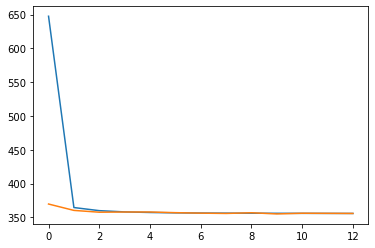

In [152]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### ---- Testing models ----

In [62]:
#Testing the XGBregressor model
n_estimators = [3000]
learning_rate = [0.01]
result = xgb_model(n_estimators=n_estimators, 
                   learning_rate=learning_rate,
                  training_data=(job_features_train, salaries_train),
                   validation_data=(job_features_valid, salaries_valid),
                  testing_data=(job_features_test, salaries_test),
                    directory='xgb_performance',
                  filename='second_performance')
print(result)
#Best MSE: 357.935199242836
#Best n_estimator and learning_rate: 3000.0,0.01

In [166]:
#Evaluating hyperband neural network
model_hb.evaluate(job_features_test, salaries_test, verbose=3)
#Best MSE: 364.09112548828125
model_hb.save('neuralnetowrk_weights/model_hb.h5')

[364.09112548828125, 364.09112548828125]

In [6]:
#Evaluating random search
model_rs.evaluate(job_features_test, salaries_test, verbose=1)
#Best MSE: 361.3115539550781
model_rs.save('neuralnetowrk_weights/model_rs.h5')

In [139]:
#Evaluating Bayesian Optimization
model_bo.evaluate(job_features_test, salaries_test, verbose=1)
#Best MSE: 357.3861083984375
model_bo.save('neuralnetowrk_weights/model_bo.h5')

### ---- Selecting the best model  ----

In [132]:
#One hidden layer neural network with BayesianOptimization for hyper parameter tuning

## Part 4 - DEPLOY

### ---- Automating pipeline ----

In [159]:
test_features = pd.read_csv('./data/test_features.csv')

In [162]:
def preprocessing_pipeline(data=test_features, scaler=scaler):
    data = pre_processing(data=data)
    data[['yearsExperience', 'milesFromMetropolis']] = scaler.fit_transform(data[['yearsExperience', 'milesFromMetropolis']])
    return data

In [163]:
processed_test_features = preprocessing_pipeline(data = test_features, scaler=scaler)

### ---- Deploying solution ----

In [198]:
def making_predictions(data= processed_test_features):
    model = load_model('./neuralnetowrk_weights/model_bo.h5')
    predictions = model.predict(processed_test_features)
    
    predictions = pd.DataFrame(predictions)
    predictions.columns = ['predicted_salary']
    predictions = pd.concat([test_features['jobId'],predictions], axis=1)
    predictions.to_csv('predicted_salary.csv')
    return predictions   

In [199]:
making_predictions()

jobId  predicted_salary
0       JOB1362685407687        112.543755
1       JOB1362685407688         93.704002
2       JOB1362685407689        184.568054
3       JOB1362685407690        104.520447
4       JOB1362685407691        114.641663
...                  ...               ...
999995  JOB1362686407682        169.382843
999996  JOB1362686407683        105.918945
999997  JOB1362686407684         54.804760
999998  JOB1362686407685        163.437393
999999  JOB1362686407686        112.739761

[1000000 rows x 2 columns]